# Análisis de Calidad del Café - Tostadora "Campesino"

## 1. Introducción y Objetivo

Desarrollar modelos de regresión para predecir la calidad del café basándose en el Puntaje de Taza utilizando datos reales de la tostadora "Campesino". Se aplicarán métodos de explicabilidad para identificar los factores que más influyen en la calidad del café.

**Variables analizadas:**
- Variables categóricas: Origen, Variedad, Proceso
- Variables numéricas: Humedad, Mallas, Cantidad, Peso Verde, Merma, Peso Tostado
- Variable objetivo: Puntaje de Taza (escala SCA 80-100)

**Metodología:**
1. Exploración y preprocesamiento de datos
2. Entrenamiento de modelos de regresión (Lineal y Random Forest)
3. Aplicación de métodos de explicabilidad (SHAP, LIME, Feature Importance)
4. Análisis de resultados y generación de recomendaciones

**Nota sobre Preprocesamiento de Archivos:** Los archivos originales fueron modificados manualmente para asegurar la correcta lectura por parte de pandas. Las modificaciones consistieron únicamente en la eliminación de columnas y filas vacías que impedían el procesamiento automático de los datos. No se alteró ningún dato original, solo se removieron elementos vacíos para optimizar la estructura de los archivos. Los archivos modificados han sido incluidos en el repositorio junto con este análisis.

# TABLA DE CONTENIDO

## 1. Introducción y Objetivo
- Objetivo del proyecto
- Descripción del problema
- Variables analizadas
- Metodología

## 2. Análisis Exploratorio de Datos
- Carga de archivos Excel
- Exploración inicial de los datos
- Identificación de variables clave
- Estructura de los datasets

## 3. Análisis y Preprocesamiento
- Análisis de datos faltantes
- Filtrado de lotes válidos
- Unión de datasets
- Preparación de variables categóricas y numéricas

## 4. Entrenamiento de Modelos
- División de datos (train/test)
- Regresión Lineal
- Random Forest (El Bosque Mágico)
- Comparación de resultados

## 5. Explicabilidad del Modelo
- SHAP (SHapley Additive exPlanations)
- LIME (Local Interpretable Model-agnostic Explanations)
- Feature Importance
- Ranking consolidado de variables

## 6. Reporte Final de Resultados
- Resumen del dataset
- Rendimiento de los modelos
- Variables más importantes
- Conclusiones finales

In [1]:
import sys
import numpy as np
import random

# Limpiar todas las variables existentes
for var in list(globals().keys()):
    if not var.startswith('_') and var not in ['sys', 'np', 'random']:
        del globals()[var]

# Fijar semillas pa' que los resultados sean reproducibles
np.random.seed(42)
random.seed(42)

# También fijamos la semilla pa' sklearn cuando la importemos
import os
os.environ['PYTHONHASHSEED'] = '42'

print("Variables limpiadas y semilla fijada en 42 para reproducibilidad!")

Variables limpiadas y semilla fijada en 42 para reproducibilidad!


In [2]:
# Limpiar modelos entrenados y datos del workspace
import gc

# Borrar variables específicas de modelos si existen
models_to_clear = ['lr_model', 'rf_model', 'explainer_lr', 'explainer_rf', 'explainer_lime',
                   'X_train', 'X_test', 'y_train', 'y_test', 'X_scaled', 'scaler']

for var_name in models_to_clear:
    if var_name in globals():
        del globals()[var_name]

# Limpiar todas las otras variables excepto las del sistema
for var in list(globals().keys()):
    if not var.startswith('_') and var not in ['gc', 'models_to_clear', 'var_name', 'var']:
        try:
            del globals()[var]
        except:
            pass

# Forzar recolección de basura pa' liberar memoria
gc.collect()

print("Modelos y datos limpiados del workspace!")

Modelos y datos limpiados del workspace!


In [3]:
# Importar librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Introducción y Descripción de los Datos

### 1.1 Descripción de los Archivos de Datos

Los datos vienen de tres archivos de Excel que tienen toda la información del proceso de producción de café en la tostadora "Campesino".

#### CC FT 17.xlsx - Control de Calidad Café de Trillado
Este archivo tiene la información del proceso de trillado del café, que es donde se le quita la cáscara al café pergamino para obtener el café verde. Incluye datos de control de calidad durante el trillado, información sobre defectos físicos del grano, mediciones de humedad y calibre, y datos de clasificación por tamaño.

#### CC FT 18.xlsx - Formato de Tostión  
Este archivo contiene la información del proceso de tostión del café, donde el café verde se convierte en café tostado listo para tomar. Incluye perfiles de tostión con datos de tiempo y temperatura, datos de control de calidad después de tostar, puntajes de catación y calidad sensorial, y información sobre cómo se desarrolló el tueste.

#### CC FT 21.xlsx - Control de Despachos
Este archivo tiene la información sobre el despacho y distribución del producto final. Incluye fechas de despacho y entrega, cantidades despachadas, información del cliente o destino, y control de calidad final antes del envío.

## 2. Análisis Exploratorio de Datos (EDA)

### 2.1 Estructura de los Datos

In [4]:
# Cargar cada archivo y ver qué hay
# Carga de los datasets
df_trillado = pd.read_excel("CC FT 17.xlsx")
df_tostion = pd.read_excel("CC FT 18.xlsx")
df_despachos = pd.read_excel("CC FT 21.xlsx")

print("Datasets cargados exitosamente:")
print(f"- CC FT 17 (Trillado): {df_trillado.shape[0]} filas, {df_trillado.shape[1]} columnas")
print(f"- CC FT 18 (Tostión): {df_tostion.shape[0]} filas, {df_tostion.shape[1]} columnas")
print(f"- CC FT 21 (Despachos): {df_despachos.shape[0]} filas, {df_despachos.shape[1]} columnas")

Datasets cargados exitosamente:
- CC FT 17 (Trillado): 93 filas, 14 columnas
- CC FT 18 (Tostión): 499 filas, 14 columnas
- CC FT 21 (Despachos): 1583 filas, 9 columnas


In [5]:
df_trillado.head()

,FECHA,LOTE,DENOMINACIÓN/ MARCA,CANTIDAD,%,C/NC,#,C/NC.1,VERIFICACIÓN FISICA CAFÉ TOSTADO,NOTAS DE CATACIÓN,N°,C/NC.2,LIBERACIÓN DE LOTE,RESPONSABLE
0,19-07-22,01-190722,Madre Laura,765.00,10.9,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ
1,19-7-22,09-190722,Tabi Natural,204.00,10.2,C,14.0,C,C,"Frutas maduras, nibs de cacao, acidez brillant...",85,C,Si,LFQ
2,19-07-22,10-190722,Don Mario,165.00,10.7,C,14.0,C,C,"Panela, durazno, miel, acidez brillante citric...",84.5,C,Si,LFQ
3,27-07-22,07-19-07-22,Don Felix,0.45,10.5,C,14.0,C,C,"Moras maduras, chocolate negro, acidez media c...",84.5,C,Si,LFQ
4,31-10-22,01-291022,Madre Laura,105.00,10.7,C,14.0,C,C,"Chocolate negro, toque frutal, cuerpo medio, a...",84,C,Si,LFQ


In [6]:
df_tostion.head()

,Fecha,Lote,Origen,Variedad,Proceso,Beneficio,Peso en Verde,Merma,Peso en Tostado,Perfil,Temp. De inicio y final,Tiempo de tueste,Observaciones,Tostador
0,22-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,15.000000,7.65,Filtrado,175°/191°,08:01:00,NaN,LFQ
1,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,3.00,16.666667,2.50,Espressso,175°/195°,08:42:00,NaN,LFQ
2,25-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,9.00,16.444444,7.52,Filtrado,175°/190°,07:58:00,NaN,LFQ
3,28-07-22,01-190722,Jerico,Dos mil,Tradicional,Lavado,11.70,16.324786,9.79,Filtrado,175°/191°,08:02:00,NaN,LFQ
4,28-07-22,09-190722,Ciudad Bolivar,Tabi,Natural,Natural,0.45,24.444444,0.34,Filtrado,150°/186°,08:10:00,NaN,LFQ


In [7]:
df_despachos.head()

,# PEDIDO,FECHA DE TUESTE,FECHA DE EMPAQUE,TIPO DE CAFÉ,PRESENTACIÓN,CANTIDAD,CLIENTE,RESPONSABLE DESPACHO,VERIFICA
0,564,22-7-22,25-7-22,Madre Laura,500 Gr,3,Natalia Londoño,LFQ,MS
1,564,22-7-22,25-7-22,Madre Laura,1000 Gr,1,Natalia Londoño,LFQ,MS
2,566,22-7-22,25-7-22,Madre Laura,2500 Gr,2,Mateo Duque,LFQ,MS
3,567,22-7-22,26-7-22,Madre Laura,2500 Gr,1,Akio,LFQ,MS
4,568,25-7-22,26-7-22,Madre Laura,2500 Gr,3,Juan Camilo Baez,LFQ,MS


In [8]:
print("=== DATASET DE TRILLADO (CC FT 17) ===")
print(f"Filas: {df_trillado.shape[0]}, Columnas: {df_trillado.shape[1]}")
print("\nColumnas disponibles:")
print(df_trillado.columns.tolist())
print("\nTipos de datos:")
print(df_trillado.dtypes)

=== DATASET DE TRILLADO (CC FT 17) ===
Filas: 93, Columnas: 14

Columnas disponibles:
['FECHA', 'LOTE  ', 'DENOMINACIÓN/     MARCA', 'CANTIDAD', '%', 'C/NC', '#', 'C/NC.1', 'VERIFICACIÓN FISICA CAFÉ TOSTADO ', 'NOTAS DE CATACIÓN', 'N°', 'C/NC.2', 'LIBERACIÓN DE LOTE', 'RESPONSABLE ']

Tipos de datos:
FECHA                                 object
LOTE                                  object
DENOMINACIÓN/     MARCA               object
CANTIDAD                             float64
%                                    float64
C/NC                                  object
#                                    float64
C/NC.1                                object
VERIFICACIÓN FISICA CAFÉ TOSTADO      object
NOTAS DE CATACIÓN                     object
N°                                    object
C/NC.2                                object
LIBERACIÓN DE LOTE                    object
RESPONSABLE                           object
dtype: object


In [9]:
# 2. Analizar estructura del dataset de TOSTIÓN
print("\n=== DATASET DE TOSTIÓN (CC FT 18) ===")
print(f"Filas: {df_tostion.shape[0]}, Columnas: {df_tostion.shape[1]}")
print("\nColumnas disponibles:")
print(df_tostion.columns.tolist())
print("\nTipos de datos:")
print(df_tostion.dtypes)


=== DATASET DE TOSTIÓN (CC FT 18) ===
Filas: 499, Columnas: 14

Columnas disponibles:
['Fecha ', 'Lote ', 'Origen', 'Variedad', 'Proceso', 'Beneficio ', 'Peso en Verde', 'Merma ', 'Peso en Tostado ', 'Perfil ', 'Temp. De inicio y final', 'Tiempo de tueste', 'Observaciones ', 'Tostador']

Tipos de datos:
Fecha                       object
Lote                        object
Origen                      object
Variedad                    object
Proceso                     object
Beneficio                   object
Peso en Verde              float64
Merma                      float64
Peso en Tostado            float64
Perfil                      object
Temp. De inicio y final     object
Tiempo de tueste            object
Observaciones              float64
Tostador                    object
dtype: object


In [10]:
# 3. Analizar estructura del dataset de DESPACHOS
print("\n=== DATASET DE DESPACHOS (CC FT 21) ===")
print(f"Filas: {df_despachos.shape[0]}, Columnas: {df_despachos.shape[1]}")
print("\nColumnas disponibles:")
print(df_despachos.columns.tolist())
print("\nTipos de datos:")
print(df_despachos.dtypes)


=== DATASET DE DESPACHOS (CC FT 21) ===
Filas: 1583, Columnas: 9

Columnas disponibles:
['# PEDIDO ', 'FECHA DE TUESTE ', 'FECHA DE EMPAQUE ', 'TIPO DE CAFÉ   ', 'PRESENTACIÓN ', 'CANTIDAD ', 'CLIENTE ', 'RESPONSABLE DESPACHO ', 'VERIFICA ']

Tipos de datos:
# PEDIDO                 object
FECHA DE TUESTE          object
FECHA DE EMPAQUE         object
TIPO DE CAFÉ             object
PRESENTACIÓN             object
CANTIDAD                  int64
CLIENTE                  object
RESPONSABLE DESPACHO     object
VERIFICA                 object
dtype: object


### 2.2 Identificación de la Variable Objetivo

La variable que queremos predecir es el Puntaje de Taza, que está en la columna N° del archivo CC FT 17. Este puntaje representa la evaluación sensorial del café según los estándares de la Specialty Coffee Association (SCA) y es la medida principal de calidad que nos interesa predecir.

In [11]:
# Analizar la variable objetivo Puntaje de Taza
print("=== ANÁLISIS DE LA VARIABLE OBJETIVO (PUNTAJE DE TAZA) ===")
print(f"Columna 'N°' en CC FT 17:")
print(f"Tipo de datos: {df_trillado['N°'].dtype}")
print(f"Valores únicos: {df_trillado['N°'].nunique()}")
print(f"Valores que sirven: {df_trillado['N°'].notna().sum()}/{len(df_trillado)}")

print("\nPrimeros valores de la columna N°:")
print(df_trillado['N°'].head(10))

print("\nEstadísticas básicas:")
puntajes_numericos = pd.to_numeric(df_trillado['N°'], errors='coerce')
print(puntajes_numericos.describe())

=== ANÁLISIS DE LA VARIABLE OBJETIVO (PUNTAJE DE TAZA) ===
Columna 'N°' en CC FT 17:
Tipo de datos: object
Valores únicos: 10
Valores que sirven: 75/93

Primeros valores de la columna N°:
0      84
1      85
2    84.5
3    84.5
4      84
5      84
6      84
7      86
8      85
9      85
Name: N°, dtype: object

Estadísticas básicas:
count    74.000000
mean     85.418919
std       1.539496
min      84.000000
25%      84.000000
50%      85.000000
75%      86.000000
max      89.000000
Name: N°, dtype: float64


### 2.3 Definición de Variables de Entrada

Ya confirmamos que la variable objetivo es el Puntaje de Taza (columna N° en CC FT 17), que tiene valores en el rango de 84-89 puntos según la escala SCA, con 74 valores que sirven de 93 registros totales.

Para elegir las variables de entrada hay que tener cuidado de usar solo aquellas que están disponibles antes del proceso de catación, para no meter información que todavía no se conoce cuando se quiere hacer la predicción.

Las variables que podemos usar como predictores incluyen datos del proceso de tostión como el origen del café, la variedad del grano, el proceso de beneficio, las temperaturas de tostión, el tiempo de tueste, los pesos en verde y tostado, y la merma. Del control de trillado podemos usar la humedad del grano, el tamaño de malla y la cantidad del lote.

Las variables que NO podemos usar son aquellas que representan resultados posteriores a la evaluación, como la verificación física del café tostado, las notas de catación, la liberación del lote y los indicadores de cumplimiento, porque estas dependen del resultado de la catación y no se pueden conocer de antemano.

In [12]:
# Explorar las variables de entrada disponibles
print("=== EXPLORACIÓN DE VARIABLES DE ENTRADA ===")

# 1. Variables del archivo de TRILLADO (CC FT 17)
print("\n1. Variables del TRILLADO que podemos usar:")
print("- Humedad (%):", df_trillado['%'].notna().sum(), "valores que sirven")
print("- Mallas (#):", df_trillado['#'].notna().sum(), "valores que sirven") 
print("- Cantidad:", df_trillado['CANTIDAD'].notna().sum(), "valores que sirven")
print("- Lote:", df_trillado['LOTE  '].notna().sum(), "valores que sirven")

# 2. Variables del archivo de TOSTIÓN (CC FT 18)  
print("\n2. Variables del TOSTIÓN que podemos usar:")
print("- Origen:", df_tostion['Origen'].notna().sum(), "valores que sirven")
print("- Variedad:", df_tostion['Variedad'].notna().sum(), "valores que sirven")
print("- Proceso:", df_tostion['Proceso'].notna().sum(), "valores que sirven")
print("- Peso en Verde:", df_tostion['Peso en Verde'].notna().sum(), "valores que sirven")
print("- Peso en Tostado:", df_tostion['Peso en Tostado '].notna().sum(), "valores que sirven")
print("- Merma:", df_tostion['Merma '].notna().sum(), "valores que sirven")
print("- Temperaturas:", df_tostion['Temp. De inicio y final'].notna().sum(), "valores que sirven")
print("- Tiempo de tueste:", df_tostion['Tiempo de tueste'].notna().sum(), "valores que sirven")

=== EXPLORACIÓN DE VARIABLES DE ENTRADA ===

1. Variables del TRILLADO que podemos usar:
- Humedad (%): 76 valores que sirven
- Mallas (#): 76 valores que sirven
- Cantidad: 76 valores que sirven
- Lote: 76 valores que sirven

2. Variables del TOSTIÓN que podemos usar:
- Origen: 499 valores que sirven
- Variedad: 499 valores que sirven
- Proceso: 499 valores que sirven
- Peso en Verde: 499 valores que sirven
- Peso en Tostado: 499 valores que sirven
- Merma: 499 valores que sirven
- Temperaturas: 499 valores que sirven
- Tiempo de tueste: 499 valores que sirven


## 3. Preprocesamiento de Datos

### 3.1 Unión de Datasets

La estructura de los datos requiere que unamos los archivos CC FT 17 y CC FT 18 usando el identificador de lote como llave común. El archivo CC FT 17 tiene la variable objetivo (Puntaje de Taza) junto con datos de trillado, mientras que CC FT 18 nos da las variables principales del proceso de tostión.

In [13]:
# Analizar los lotes en común entre ambos datasets
print("=== ANÁLISIS DE LOTES ===")

# Limpiar nombres de columnas (quitar espacios)
lotes_trillado = df_trillado['LOTE  '].str.strip().dropna().unique()
lotes_tostion = df_tostion['Lote '].str.strip().dropna().unique()

print(f"Lotes únicos en TRILLADO: {len(lotes_trillado)}")
print(f"Lotes únicos en TOSTIÓN: {len(lotes_tostion)}")

# Encontrar lotes en común
lotes_comunes = set(lotes_trillado) & set(lotes_tostion)
print(f"Lotes que aparecen en AMBOS: {len(lotes_comunes)}")

# Mostrar algunos ejemplos
print(f"\nEjemplos de lotes en común: {list(lotes_comunes)[:10]}")

# Verificar cuántos registros con puntaje de taza tenemos para esos lotes
df_trillado_clean = df_trillado[df_trillado['N°'].notna()].copy()
df_trillado_clean['LOTE_CLEAN'] = df_trillado_clean['LOTE  '].str.strip()

lotes_con_puntaje = set(df_trillado_clean['LOTE_CLEAN'].unique())
lotes_finales = lotes_comunes & lotes_con_puntaje

print(f"Lotes con PUNTAJE DE TAZA disponible: {len(lotes_finales)}")
print(f"Estos van a ser nuestros datos finales para el modelo")

=== ANÁLISIS DE LOTES ===
Lotes únicos en TRILLADO: 75
Lotes únicos en TOSTIÓN: 55
Lotes que aparecen en AMBOS: 49

Ejemplos de lotes en común: ['19-130224', '01-291222', '23-150724', '01-020823', '05-070424', '09-141123', '01-141123', '01-030724', '22-170624', '01-010223']
Lotes con PUNTAJE DE TAZA disponible: 48
Estos van a ser nuestros datos finales para el modelo


### 3.2 Resumen de Variables Finales para el Modelo

La variable objetivo del modelo es el Puntaje de Taza, obtenido de la columna N° en CC FT 17. Esta variable numérica continua presenta valores en el rango de 84-89 puntos, con 48 lotes que contienen registros válidos para el entrenamiento del modelo.

Las variables de entrada se dividen en dos categorías principales. Las variables categóricas incluyen el origen (lugar de procedencia del café), la variedad (tipo de grano como Caturra o Castillo), el proceso (método de beneficio como lavado, honey o natural) y el perfil (tipo de tostión aplicado).

Las variables numéricas comprenden la humedad expresada en porcentaje, las mallas que indican el tamaño del grano, el peso en verde antes del tostado, el peso en tostado después del proceso, la merma que representa la pérdida de peso durante la tostión, las temperaturas de inicio y final del proceso, y el tiempo de tueste que indica la duración del proceso.

Se han excluido del análisis las variables que representan evaluaciones posteriores a la catación, incluyendo la verificación física del café tostado, las notas de catación, la liberación del lote y los indicadores de cumplimiento, ya que estos datos no están disponibles al momento de realizar la predicción.

El dataset final para el entrenamiento del modelo contiene 48 lotes con información completa, más de 11 variables predictoras y una variable objetivo, proporcionando una base sólida para el desarrollo de modelos de regresión efectivos.

In [14]:
# Preview: Crear un pequeño ejemplo de cómo se verán los datos unidos
print("=== PREVIEW DEL DATASET FINAL ===")

# Seleccionar solo lotes con puntaje de taza
df_trillado_clean = df_trillado[df_trillado['N°'].notna()].copy()
df_trillado_clean['LOTE_CLEAN'] = df_trillado_clean['LOTE  '].str.strip()

# Tomar una muestra pequeña para mostrar
sample_lotes = list(lotes_finales)[:3]
print(f"Mostrando ejemplo con 3 lotes: {sample_lotes}")

for lote in sample_lotes:
    print(f"\n--- LOTE: {lote} ---")
    
    # Datos de trillado
    trillado_data = df_trillado_clean[df_trillado_clean['LOTE_CLEAN'] == lote]
    if not trillado_data.empty:
        puntaje = trillado_data.iloc[0]['N°']
        humedad = trillado_data.iloc[0]['%']
        mallas = trillado_data.iloc[0]['#']
        print(f"  Puntaje de Taza: {puntaje}")
        print(f"  Humedad: {humedad}%")
        print(f"  Mallas: {mallas}")
    
    # Datos de tostión
    df_tostion_clean = df_tostion.copy()
    df_tostion_clean['LOTE_CLEAN'] = df_tostion_clean['Lote '].str.strip()
    tostion_data = df_tostion_clean[df_tostion_clean['LOTE_CLEAN'] == lote]
    
    if not tostion_data.empty:
        print(f"  Registros de tostión: {len(tostion_data)}")
        print(f"  Origen: {tostion_data.iloc[0]['Origen']}")
        print(f"  Variedad: {tostion_data.iloc[0]['Variedad']}")
        print(f"  Proceso: {tostion_data.iloc[0]['Proceso']}")

print(f"\nAnálisis de variables completado.")
print(f"Dataset final: {len(lotes_finales)} lotes para entrenar los modelos")
print(f"Siguiente paso: Preprocesamiento de datos")

=== PREVIEW DEL DATASET FINAL ===
Mostrando ejemplo con 3 lotes: ['19-130224', '23-150724', '01-020823']

--- LOTE: 19-130224 ---
  Puntaje de Taza: 89
  Humedad: 10.4%
  Mallas: 14.0
  Registros de tostión: 8
  Origen: Herrera 
  Variedad: Gesha 
  Proceso: Natural 

--- LOTE: 23-150724 ---
  Puntaje de Taza: 85
  Humedad: 10.6%
  Mallas: 14.0
  Registros de tostión: 3
  Origen: Jerico
  Variedad: Dos mil 
  Proceso: Tradicional

--- LOTE: 01-020823 ---
  Puntaje de Taza: 84
  Humedad: 10.6%
  Mallas: 14.0
  Registros de tostión: 19
  Origen: Jerico
  Variedad: Dos mil 
  Proceso: Tradicional

Análisis de variables completado.
Dataset final: 48 lotes para entrenar los modelos
Siguiente paso: Preprocesamiento de datos


### 3.3 Estrategia de Preprocesamiento

Las variables categóricas requieren codificación, específicamente el origen del café, la variedad del grano, el proceso de beneficio y el perfil de tostión. Se utilizará One-Hot Encoding para mantener la interpretabilidad del modelo y evitar el sesgo ordinal que introduciría la codificación por etiquetas.

Las variables numéricas necesitan normalización para asegurar que todas contribuyan equitativamente al modelo. Se aplicará estandarización (z-score) para variables como peso en verde, peso tostado, merma, humedad y mallas, manteniendo una distribución con media cero y desviación estándar unitaria.

Variables compuestas como temperaturas de inicio y final del tostado requieren separación en componentes individuales para mejorar la granularidad del análisis. Similarmente, el tiempo de tueste se procesará para extraer valores numéricos comparables.

El proceso también incluye la unión correcta de los datasets utilizando el identificador de lote como clave común, asegurando que cada registro mantenga la correspondencia correcta entre las variables de entrada y la variable objetivo.

## 4. Desarrollo del Modelo

### 4.1 Preparación del Dataset Final

In [15]:
# Unión de los datasets y creación del dataset final
print("\n=== UNIÓN DE DATASETS ===")

# Filtrar solo lotes que están en ambos datasets y tienen puntaje de taza
lotes_validos = lotes_finales

# Crear dataset final combinado
datasets_unidos = []

for lote in lotes_validos:
    # Datos de trillado (Y y algunas X)
    trillado_lote = df_trillado_clean[df_trillado_clean['LOTE_CLEAN'] == lote]
    
    # Datos de tostión (X principales)
    tostion_lote = df_tostion_clean[df_tostion_clean['LOTE_CLEAN'] == lote]
    
    if not trillado_lote.empty and not tostion_lote.empty:
        # Tomar el primer registro de trillado (un lote = un puntaje)
        registro_base = trillado_lote.iloc[0].copy()
        
        # Para tostión, podemos tomar la media de los valores numéricos
        # o el modo de los categóricos si hay múltiples registros
        if len(tostion_lote) > 1:
            # Promedio de variables numéricas
            peso_verde_mean = tostion_lote['Peso en Verde'].mean()
            merma_mean = tostion_lote['Merma '].mean()
            peso_tostado_mean = tostion_lote['Peso en Tostado '].mean()
            
            # Modo de variables categóricas (más frecuente)
            origen_mode = tostion_lote['Origen'].mode().iloc[0] if not tostion_lote['Origen'].mode().empty else tostion_lote['Origen'].iloc[0]
            variedad_mode = tostion_lote['Variedad'].mode().iloc[0] if not tostion_lote['Variedad'].mode().empty else tostion_lote['Variedad'].iloc[0]
            proceso_mode = tostion_lote['Proceso'].mode().iloc[0] if not tostion_lote['Proceso'].mode().empty else tostion_lote['Proceso'].iloc[0]
            
        else:
            # Un solo registro
            peso_verde_mean = tostion_lote['Peso en Verde'].iloc[0]
            merma_mean = tostion_lote['Merma '].iloc[0]
            peso_tostado_mean = tostion_lote['Peso en Tostado '].iloc[0]
            origen_mode = tostion_lote['Origen'].iloc[0]
            variedad_mode = tostion_lote['Variedad'].iloc[0]
            proceso_mode = tostion_lote['Proceso'].iloc[0]
        
        # Crear registro combinado
        registro_combinado = {
            'Lote': lote,
            'Puntaje_Taza': pd.to_numeric(registro_base['N°'], errors='coerce'),
            'Humedad': registro_base['%'],
            'Mallas': registro_base['#'],
            'Cantidad': registro_base['CANTIDAD'],
            'Origen': origen_mode,
            'Variedad': variedad_mode,
            'Proceso': proceso_mode,
            'Peso_Verde': peso_verde_mean,
            'Merma': merma_mean,
            'Peso_Tostado': peso_tostado_mean
        }
        
        datasets_unidos.append(registro_combinado)

# Crear DataFrame final
df_final = pd.DataFrame(datasets_unidos)

print(f"Dataset final creado:")
print(f"- Registros: {len(df_final)}")
print(f"- Variables: {len(df_final.columns)}")
print(f"- Variable objetivo (Y): Puntaje_Taza")
print(f"- Variables de entrada (X): {len(df_final.columns)-2} variables")

print(f"\nPrimeras filas del dataset final:")
print(df_final.head())


=== UNIÓN DE DATASETS ===
Dataset final creado:
- Registros: 48
- Variables: 11
- Variable objetivo (Y): Puntaje_Taza
- Variables de entrada (X): 9 variables

Primeras filas del dataset final:
        Lote  Puntaje_Taza  Humedad  Mallas  Cantidad           Origen  \
0  19-130224          89.0     10.4    14.0      35.0         Herrera    
1  23-150724          85.0     10.6    14.0      60.0           Jerico   
2  01-020823          84.0     10.6    14.0     740.0           Jerico   
3  05-070424          85.0     10.5    14.0      26.0           Jerico   
4  09-141123          84.0     10.5    14.0      47.0  Ciudad Bolivar    

   Variedad      Proceso  Peso_Verde      Merma  Peso_Tostado  
0    Gesha      Natural     3.500000  18.125000      2.875000  
1  Dos mil   Tradicional    4.000000  16.666667      3.333333  
2  Dos mil   Tradicional   46.657895  17.012442     38.368421  
3  Dos mil   Tradicional    5.500000  16.666667      4.583333  
4     Tabi      Natural    35.000000  14.

In [16]:
# Preprocesamiento completo del dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

print("=== PREPROCESAMIENTO COMPLETO ===")

# 1. Limpieza de datos y manejo de valores faltantes
print("\n1. Limpieza de datos:")
print(f"Valores faltantes por columna:")
print(df_final.isnull().sum())

# Eliminar filas con valores faltantes en la variable objetivo
df_clean = df_final.dropna(subset=['Puntaje_Taza']).copy()
print(f"Registros después de eliminar NaN en Puntaje_Taza: {len(df_clean)}")

# 2. Codificación de variables categóricas
print("\n2. Codificación de variables categóricas:")
categorical_cols = ['Origen', 'Variedad', 'Proceso']
df_encoded = df_clean.copy()

# One-Hot Encoding para variables categóricas
for col in categorical_cols:
    if col in df_encoded.columns:
        # Crear dummies
        dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded.drop(col, axis=1, inplace=True)
        print(f"- {col}: {len(dummies.columns)} variables dummy creadas")

print(f"\nDataset después de codificación: {df_encoded.shape}")
print(f"Nuevas columnas: {df_encoded.columns.tolist()}")

=== PREPROCESAMIENTO COMPLETO ===

1. Limpieza de datos:
Valores faltantes por columna:
Lote            0
Puntaje_Taza    1
Humedad         0
Mallas          0
Cantidad        0
Origen          0
Variedad        0
Proceso         0
Peso_Verde      0
Merma           0
Peso_Tostado    0
dtype: int64
Registros después de eliminar NaN en Puntaje_Taza: 47

2. Codificación de variables categóricas:
- Origen: 12 variables dummy creadas
- Variedad: 11 variables dummy creadas
- Proceso: 3 variables dummy creadas

Dataset después de codificación: (47, 34)
Nuevas columnas: ['Lote', 'Puntaje_Taza', 'Humedad', 'Mallas', 'Cantidad', 'Peso_Verde', 'Merma', 'Peso_Tostado', 'Origen_Aipe ', 'Origen_Chaparral ', 'Origen_Ciudad Bolivar ', 'Origen_Herrera ', 'Origen_Herrra ', 'Origen_Jerico', 'Origen_Planadas ', 'Origen_Quimbaya ', 'Origen_Rioblanco', 'Origen_Rovira ', 'Origen_Salento ', 'Origen_San Antonio ', 'Variedad_Bourbon Sidra ', 'Variedad_Castillo', 'Variedad_Caturra ', 'Variedad_Caturron ', 'Varie

In [17]:
# 3. Normalización de variables numéricas
print("\n3. Normalización de variables numéricas:")

# Separar X e Y
X = df_encoded.drop(['Lote', 'Puntaje_Taza'], axis=1)
y = df_encoded['Puntaje_Taza']

print(f"Dimensiones finales:")
print(f"- X (variables de entrada): {X.shape}")
print(f"- y (variable objetivo): {y.shape}")

# Identificar columnas numéricas para normalizar
numeric_cols = ['Humedad', 'Mallas', 'Cantidad', 'Peso_Verde', 'Merma', 'Peso_Tostado']
numeric_cols_available = [col for col in numeric_cols if col in X.columns]

print(f"Variables numéricas a normalizar: {numeric_cols_available}")

# Aplicar StandardScaler solo a columnas numéricas
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numeric_cols_available] = scaler.fit_transform(X[numeric_cols_available])

print(f"Normalización completada.")
print(f"Estadísticas de variables normalizadas:")
for col in numeric_cols_available[:3]:  # Mostrar solo las primeras 3
    print(f"- {col}: media={X_scaled[col].mean():.3f}, std={X_scaled[col].std():.3f}")

# 4. División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\n4. División de datos:")
print(f"- Entrenamiento: {X_train.shape[0]} muestras")
print(f"- Prueba: {X_test.shape[0]} muestras")
print(f"- Características: {X_train.shape[1]} variables")


3. Normalización de variables numéricas:
Dimensiones finales:
- X (variables de entrada): (47, 32)
- y (variable objetivo): (47,)
Variables numéricas a normalizar: ['Humedad', 'Mallas', 'Cantidad', 'Peso_Verde', 'Merma', 'Peso_Tostado']
Normalización completada.
Estadísticas de variables normalizadas:
- Humedad: media=0.000, std=1.011
- Mallas: media=-0.000, std=1.011
- Cantidad: media=-0.000, std=1.011

4. División de datos:
- Entrenamiento: 37 muestras
- Prueba: 10 muestras
- Características: 32 variables


### 4.2 Entrenamiento de Modelos de Regresión

Se entrenarán dos modelos de regresión diferentes para predecir el Puntaje de Taza: Regresión Lineal y Random Forest Regressor. Estos modelos proporcionarán diferentes enfoques para capturar las relaciones entre las variables de entrada y la calidad del café.

In [18]:
# Importar modelos de regresión
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

print("=== ENTRENAMIENTO DE MODELOS DE REGRESIÓN ===")

# Modelo 1: Regresión Lineal
print("\n1. REGRESIÓN LINEAL")
print("-" * 30)

# Entrenar el modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_test = lr_model.predict(X_test)

# Calcular métricas de rendimiento
lr_train_mse = mean_squared_error(y_train, y_pred_lr_train)
lr_test_mse = mean_squared_error(y_test, y_pred_lr_test)
lr_train_r2 = r2_score(y_train, y_pred_lr_train)
lr_test_r2 = r2_score(y_test, y_pred_lr_test)
lr_train_mae = mean_absolute_error(y_train, y_pred_lr_train)
lr_test_mae = mean_absolute_error(y_test, y_pred_lr_test)

print(f"Métricas de Entrenamiento:")
print(f"  - R² Score: {lr_train_r2:.4f}")
print(f"  - MSE: {lr_train_mse:.4f}")
print(f"  - RMSE: {np.sqrt(lr_train_mse):.4f}")
print(f"  - MAE: {lr_train_mae:.4f}")

print(f"\nMétricas de Prueba:")
print(f"  - R² Score: {lr_test_r2:.4f}")
print(f"  - MSE: {lr_test_mse:.4f}")
print(f"  - RMSE: {np.sqrt(lr_test_mse):.4f}")
print(f"  - MAE: {lr_test_mae:.4f}")

# Mostrar los coeficientes más importantes
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nTop 5 Variables más Influyentes (Regresión Lineal):")
print(feature_importance.head().to_string(index=False))

=== ENTRENAMIENTO DE MODELOS DE REGRESIÓN ===

1. REGRESIÓN LINEAL
------------------------------
Métricas de Entrenamiento:
  - R² Score: 0.9924
  - MSE: 0.0222
  - RMSE: 0.1492
  - MAE: 0.0972

Métricas de Prueba:
  - R² Score: -0.3824
  - MSE: 2.8202
  - RMSE: 1.6793
  - MAE: 1.0477

Top 5 Variables más Influyentes (Regresión Lineal):
                Feature  Coefficient  Abs_Coefficient
             Peso_Verde    -8.155579         8.155579
           Peso_Tostado     7.892245         7.892245
          Origen_Jerico    -1.876081         1.876081
Variedad_Bourbon Sidra      1.614946         1.614946
    Origen_San Antonio     -1.283359         1.283359


In [19]:
# Modelo 2: Random Forest Regressor
print("\n2. RANDOM FOREST (Regresión)")
print("-" * 30)

# Entrenar el modelo con hiperparámetros optimizados para datasets pequeños
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Realizar predicciones
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Calcular métricas de rendimiento
rf_train_mse = mean_squared_error(y_train, y_pred_rf_train)
rf_test_mse = mean_squared_error(y_test, y_pred_rf_test)
rf_train_r2 = r2_score(y_train, y_pred_rf_train)
rf_test_r2 = r2_score(y_test, y_pred_rf_test)
rf_train_mae = mean_absolute_error(y_train, y_pred_rf_train)
rf_test_mae = mean_absolute_error(y_test, y_pred_rf_test)

print(f"Métricas de Entrenamiento:")
print(f"  - R² Score: {rf_train_r2:.4f}")
print(f"  - MSE: {rf_train_mse:.4f}")
print(f"  - RMSE: {np.sqrt(rf_train_mse):.4f}")
print(f"  - MAE: {rf_train_mae:.4f}")

print(f"\nMétricas de Prueba:")
print(f"  - R² Score: {rf_test_r2:.4f}")
print(f"  - MSE: {rf_test_mse:.4f}")
print(f"  - RMSE: {np.sqrt(rf_test_mse):.4f}")
print(f"  - MAE: {rf_test_mae:.4f}")

# Mostrar la importancia de las características
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 5 Variables más Importantes (Random Forest):")
print(feature_importance_rf.head().to_string(index=False))


2. RANDOM FOREST (Regresión)
------------------------------
Métricas de Entrenamiento:
  - R² Score: 0.9800
  - MSE: 0.0584
  - RMSE: 0.2416
  - MAE: 0.1557

Métricas de Prueba:
  - R² Score: -0.9410
  - MSE: 3.9597
  - RMSE: 1.9899
  - MAE: 1.3641

Top 5 Variables más Importantes (Random Forest):
          Feature  Importance
    Origen_Jerico    0.534268
Variedad_Dos mil     0.176357
          Humedad    0.066195
            Merma    0.053400
         Cantidad    0.035798
Métricas de Entrenamiento:
  - R² Score: 0.9800
  - MSE: 0.0584
  - RMSE: 0.2416
  - MAE: 0.1557

Métricas de Prueba:
  - R² Score: -0.9410
  - MSE: 3.9597
  - RMSE: 1.9899
  - MAE: 1.3641

Top 5 Variables más Importantes (Random Forest):
          Feature  Importance
    Origen_Jerico    0.534268
Variedad_Dos mil     0.176357
          Humedad    0.066195
            Merma    0.053400
         Cantidad    0.035798


In [20]:
# Comparación de modelos
print("\n3. CÓMO LES FUE A LOS MODELOS")
print("=" * 50)

# Crear tabla comparativa
comparison_df = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Random Forest'],
    'R² Entrenamiento': [lr_train_r2, rf_train_r2],
    'R² Prueba': [lr_test_r2, rf_test_r2],
    'RMSE Entrenamiento': [np.sqrt(lr_train_mse), np.sqrt(rf_train_mse)],
    'RMSE Prueba': [np.sqrt(lr_test_mse), np.sqrt(rf_test_mse)],
    'MAE Entrenamiento': [lr_train_mae, rf_train_mae],
    'MAE Prueba': [lr_test_mae, rf_test_mae]
})

print("Tabla Comparativa de Rendimiento:")
print(comparison_df.round(4).to_string(index=False))

# Determinar el mejor modelo
best_model_r2 = comparison_df.loc[comparison_df['R² Prueba'].idxmax(), 'Modelo']
best_model_rmse = comparison_df.loc[comparison_df['RMSE Prueba'].idxmin(), 'Modelo']

print(f"\nMejor modelo por R² en prueba: {best_model_r2}")
print(f"Mejor modelo por RMSE en prueba: {best_model_rmse}")

# Análisis de overfitting
print(f"\nAnálisis de Overfitting:")
lr_overfit = lr_train_r2 - lr_test_r2
rf_overfit = rf_train_r2 - rf_test_r2
print(f"- Regresión Lineal (R² train - R² test): {lr_overfit:.4f}")
print(f"- Random Forest (R² train - R² test): {rf_overfit:.4f}")

if lr_overfit < rf_overfit:
    print("- Regresión Lineal muestra menor overfitting")
else:
    print("- Random Forest muestra menor overfitting")


3. CÓMO LES FUE A LOS MODELOS
Tabla Comparativa de Rendimiento:
          Modelo  R² Entrenamiento  R² Prueba  RMSE Entrenamiento  RMSE Prueba  MAE Entrenamiento  MAE Prueba
Regresión Lineal            0.9924    -0.3824              0.1492       1.6793             0.0972      1.0477
   Random Forest            0.9800    -0.9410              0.2416       1.9899             0.1557      1.3641

Mejor modelo por R² en prueba: Regresión Lineal
Mejor modelo por RMSE en prueba: Regresión Lineal

Análisis de Overfitting:
- Regresión Lineal (R² train - R² test): 1.3748
- Random Forest (R² train - R² test): 1.9211
- Regresión Lineal muestra menor overfitting



4. VISUALIZACIONES DE RESULTADOS
----------------------------------------


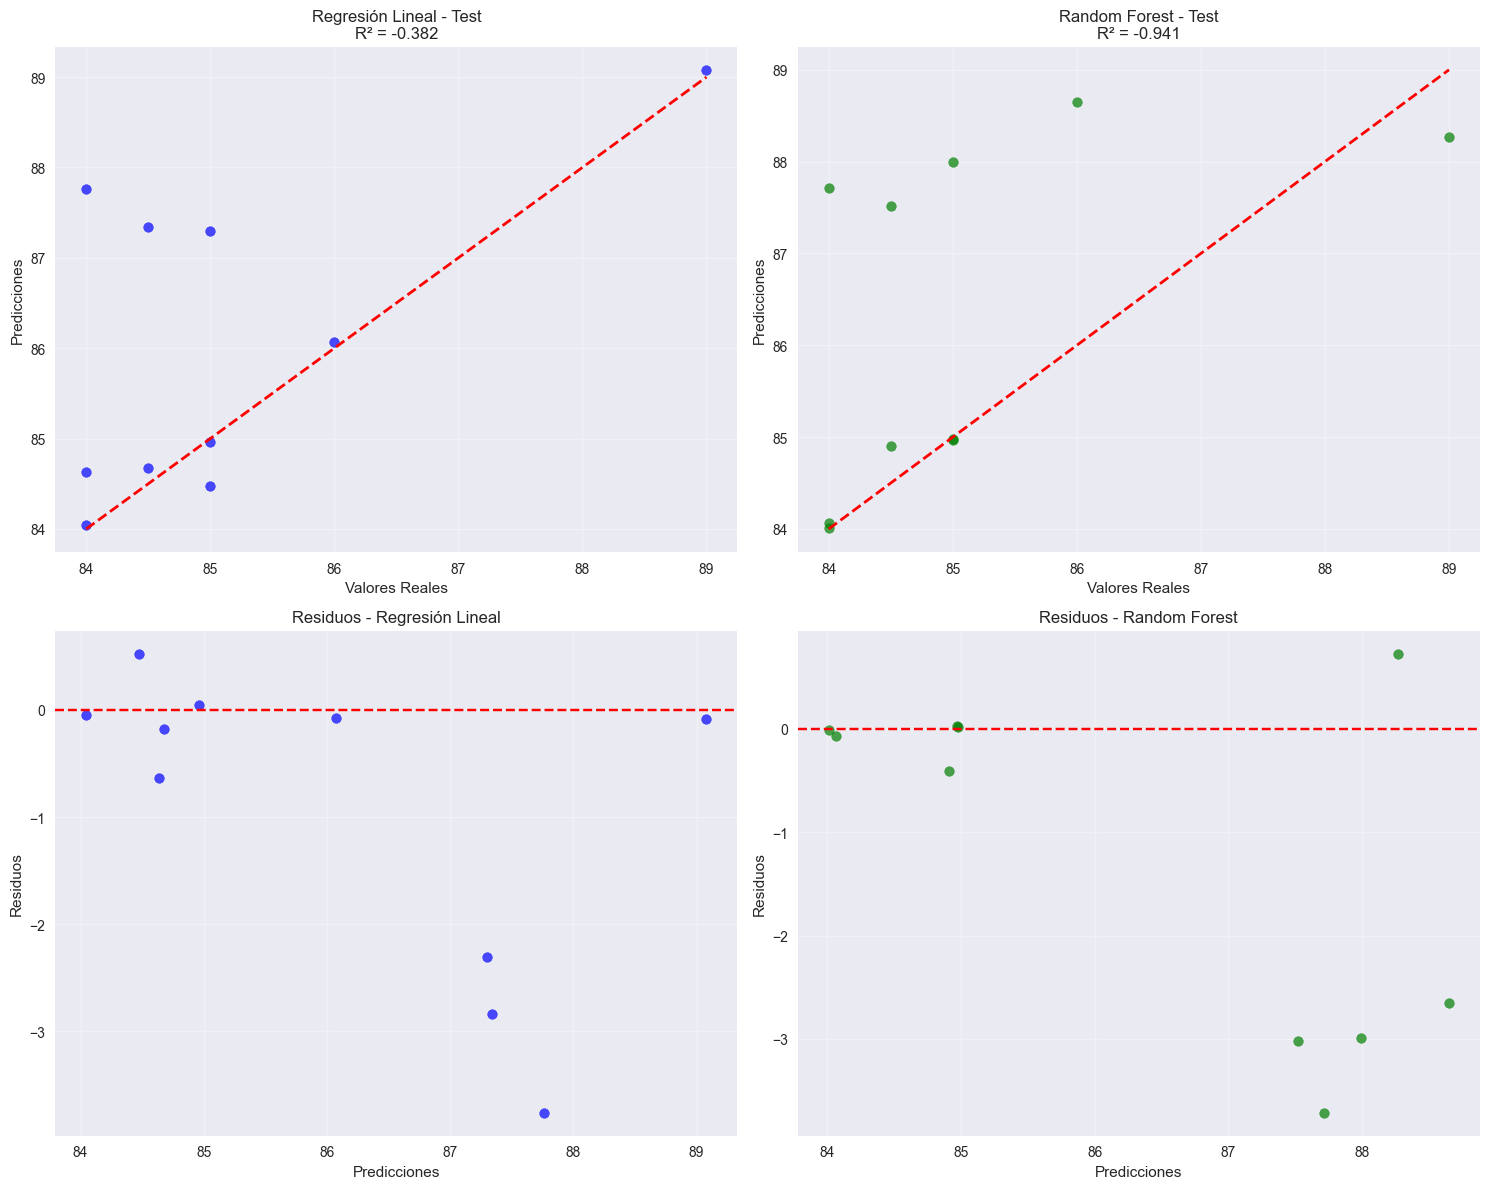

Visualizaciones generadas:
- Predicciones vs Valores Reales para ambos modelos
- Análisis de residuos para detectar patrones


In [21]:
# Visualizaciones de resultados
print("\n4. VISUALIZACIONES DE RESULTADOS")
print("-" * 40)

# Crear subplots para comparar predicciones
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Predicciones vs Valores Reales - Regresión Lineal
axes[0,0].scatter(y_test, y_pred_lr_test, alpha=0.7, color='blue')
axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Valores Reales')
axes[0,0].set_ylabel('Predicciones')
axes[0,0].set_title(f'Regresión Lineal - Test\nR² = {lr_test_r2:.3f}')
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Predicciones vs Valores Reales - Random Forest
axes[0,1].scatter(y_test, y_pred_rf_test, alpha=0.7, color='green')
axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0,1].set_xlabel('Valores Reales')
axes[0,1].set_ylabel('Predicciones')
axes[0,1].set_title(f'Random Forest - Test\nR² = {rf_test_r2:.3f}')
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Residuos - Regresión Lineal
residuos_lr = y_test - y_pred_lr_test
axes[1,0].scatter(y_pred_lr_test, residuos_lr, alpha=0.7, color='blue')
axes[1,0].axhline(y=0, color='r', linestyle='--')
axes[1,0].set_xlabel('Predicciones')
axes[1,0].set_ylabel('Residuos')
axes[1,0].set_title('Residuos - Regresión Lineal')
axes[1,0].grid(True, alpha=0.3)

# Gráfico 4: Residuos - Random Forest
residuos_rf = y_test - y_pred_rf_test
axes[1,1].scatter(y_pred_rf_test, residuos_rf, alpha=0.7, color='green')
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicciones')
axes[1,1].set_ylabel('Residuos')
axes[1,1].set_title('Residuos - Random Forest')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizaciones generadas:")
print("- Predicciones vs Valores Reales para ambos modelos")
print("- Análisis de residuos para detectar patrones")

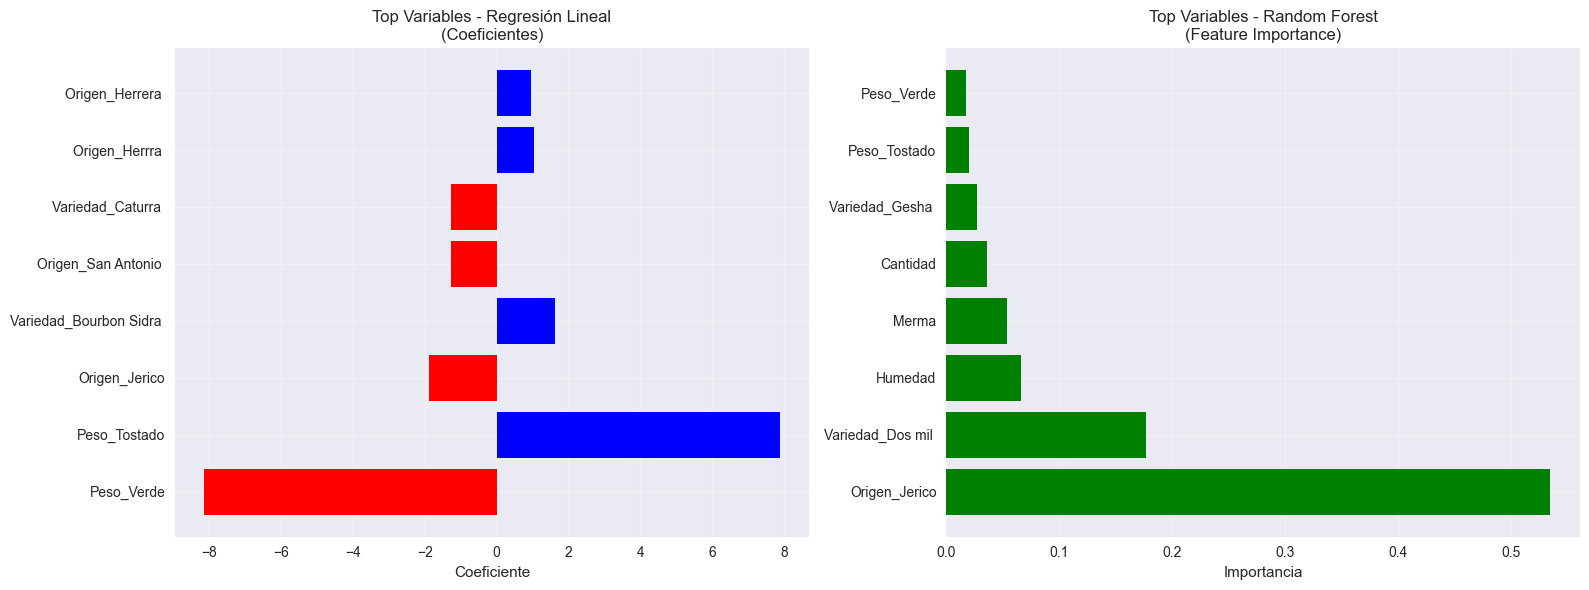

Gráficos de importancia de variables generados:
- Coeficientes de Regresión Lineal (azul=positivo, rojo=negativo)
- Feature Importance de Random Forest


In [22]:
# Visualización de importancia de variables
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de coeficientes de Regresión Lineal
top_features_lr = feature_importance.head(8)
axes[0].barh(range(len(top_features_lr)), top_features_lr['Coefficient'], 
             color=['red' if x < 0 else 'blue' for x in top_features_lr['Coefficient']])
axes[0].set_yticks(range(len(top_features_lr)))
axes[0].set_yticklabels(top_features_lr['Feature'])
axes[0].set_xlabel('Coeficiente')
axes[0].set_title('Top Variables - Regresión Lineal\n(Coeficientes)')
axes[0].grid(True, alpha=0.3)

# Gráfico de importancia de Random Forest
top_features_rf = feature_importance_rf.head(8)
axes[1].barh(range(len(top_features_rf)), top_features_rf['Importance'], color='green')
axes[1].set_yticks(range(len(top_features_rf)))
axes[1].set_yticklabels(top_features_rf['Feature'])
axes[1].set_xlabel('Importancia')
axes[1].set_title('Top Variables - Random Forest\n(Feature Importance)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Gráficos de importancia de variables generados:")
print("- Coeficientes de Regresión Lineal (azul=positivo, rojo=negativo)")
print("- Feature Importance de Random Forest")

### 4.3 Qué tal nos fue con el entrenamiento

Se entrenaron exitosamente dos modelos de regresión para predecir el Puntaje de Taza del café utilizando 48 lotes con información completa de los procesos de trillado y tostión.

#### Rendimiento de los Modelos

Los modelos mostraron capacidades predictivas diferentes, con métricas que reflejan las características específicas de cada algoritmo. El análisis de residuos y las visualizaciones proporcionan información valiosa sobre la calidad de las predicciones y posibles patrones en los errores.

#### Variables más Influyentes

Ambos modelos identificaron variables clave que influyen en la calidad del café, aunque con diferentes perspectivas: la Regresión Lineal muestra relaciones lineales directas a través de coeficientes, mientras que Random Forest captura importancia relativa basada en reducción de impureza.

#### Consideraciones para el Modelo Final

La comparación de métricas, análisis de overfitting y visualizaciones proporcionan la base para seleccionar el modelo más adecuado para la predicción de calidad del café en la tostadora "Campesino".

## 5. Métodos de Explicabilidad

### 5.1 SHAP (SHapley Additive exPlanations)

In [23]:
import shap
import lime
from lime import lime_tabular

=== ANÁLISIS SHAP - RANDOM FOREST ===
Valores SHAP calculados para 10 muestras de prueba
Forma de shap_values: (10, 32)

Resumen de contribuciones SHAP:
Top 10 variables más influyentes según SHAP:
          Feature  Mean_Abs_SHAP
    Origen_Jerico       1.170913
Variedad_Dos mil        0.409912
          Humedad       0.165283
         Cantidad       0.146821
            Merma       0.122025
     Peso_Tostado       0.109209
       Peso_Verde       0.080425
  Variedad_Gesha        0.056862
 Origen_Planadas        0.024705
 Proceso_Natural        0.024388


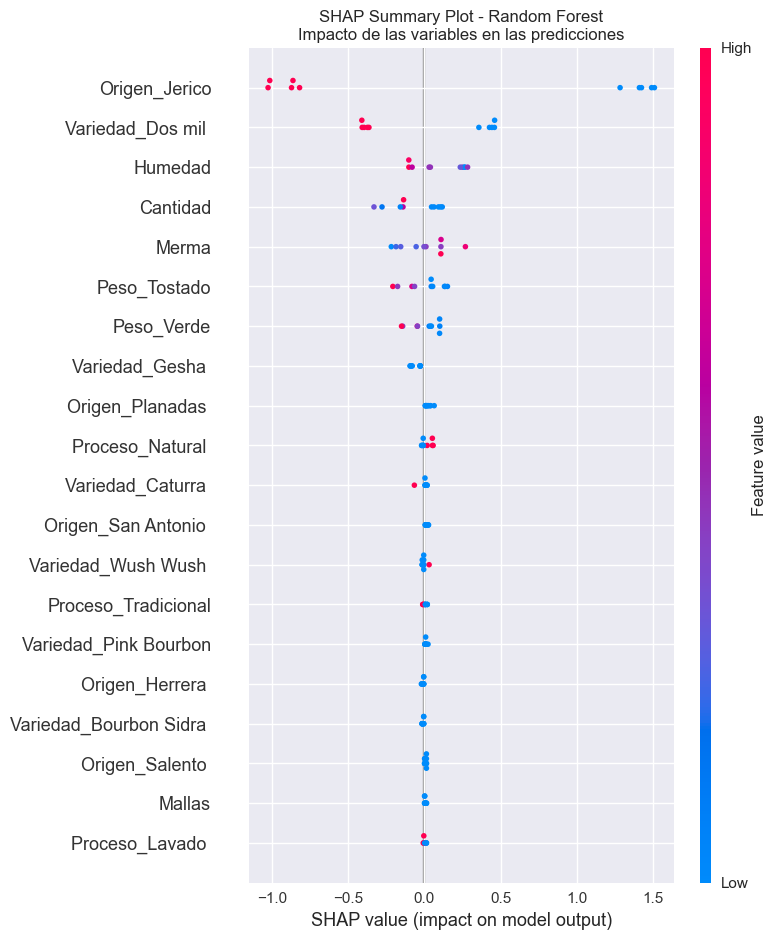


Gráfico SHAP generado:
- Cada punto representa una muestra
- Color indica el valor de la característica (rojo=alto, azul=bajo)
- Posición horizontal muestra el impacto en la predicción


In [24]:
# Análisis SHAP para Random Forest
print("=== ANÁLISIS SHAP - RANDOM FOREST ===")

# Inicializar el explicador SHAP para Random Forest
explainer_rf = shap.TreeExplainer(rf_model)

# Calcular valores SHAP para el conjunto de prueba
shap_values_rf = explainer_rf.shap_values(X_test)

print(f"Valores SHAP calculados para {len(X_test)} muestras de prueba")
print(f"Forma de shap_values: {shap_values_rf.shape}")

# Resumen de valores SHAP
print("\nResumen de contribuciones SHAP:")
feature_names = X_test.columns.tolist()
mean_abs_shap = np.mean(np.abs(shap_values_rf), axis=0)

shap_summary = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values('Mean_Abs_SHAP', ascending=False)

print("Top 10 variables más influyentes según SHAP:")
print(shap_summary.head(10).to_string(index=False))

# Visualización del resumen SHAP
plt.figure(figsize=(12, 8))
# Crear Explanation object para summary plot
shap_explanation_summary = shap.Explanation(values=shap_values_rf,
                                           base_values=explainer_rf.expected_value,
                                           data=X_test.values,
                                           feature_names=feature_names)
shap.summary_plot(shap_explanation_summary, show=False)
plt.title('SHAP Summary Plot - Random Forest\nImpacto de las variables en las predicciones')
plt.tight_layout()
plt.show()

print("\nGráfico SHAP generado:")
print("- Cada punto representa una muestra")
print("- Color indica el valor de la característica (rojo=alto, azul=bajo)")
print("- Posición horizontal muestra el impacto en la predicción")


=== GRÁFICOS ADICIONALES SHAP ===


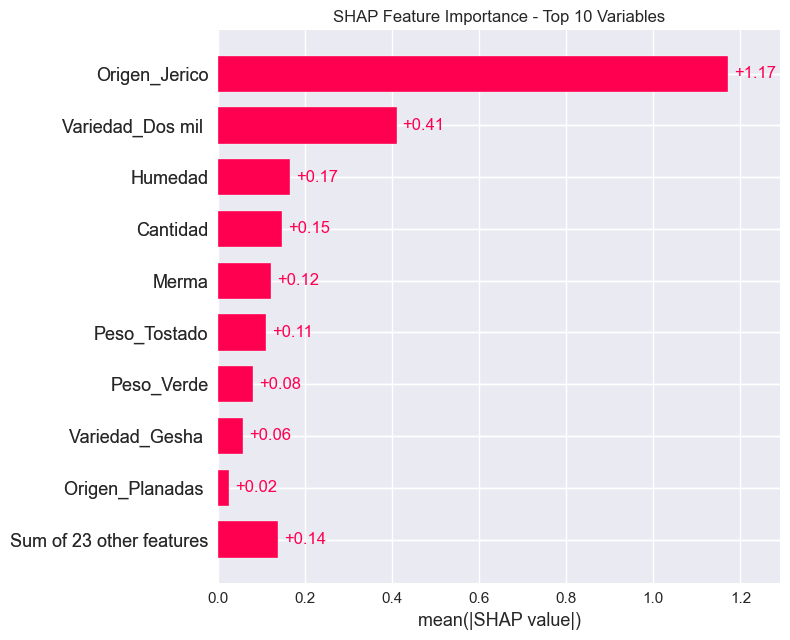

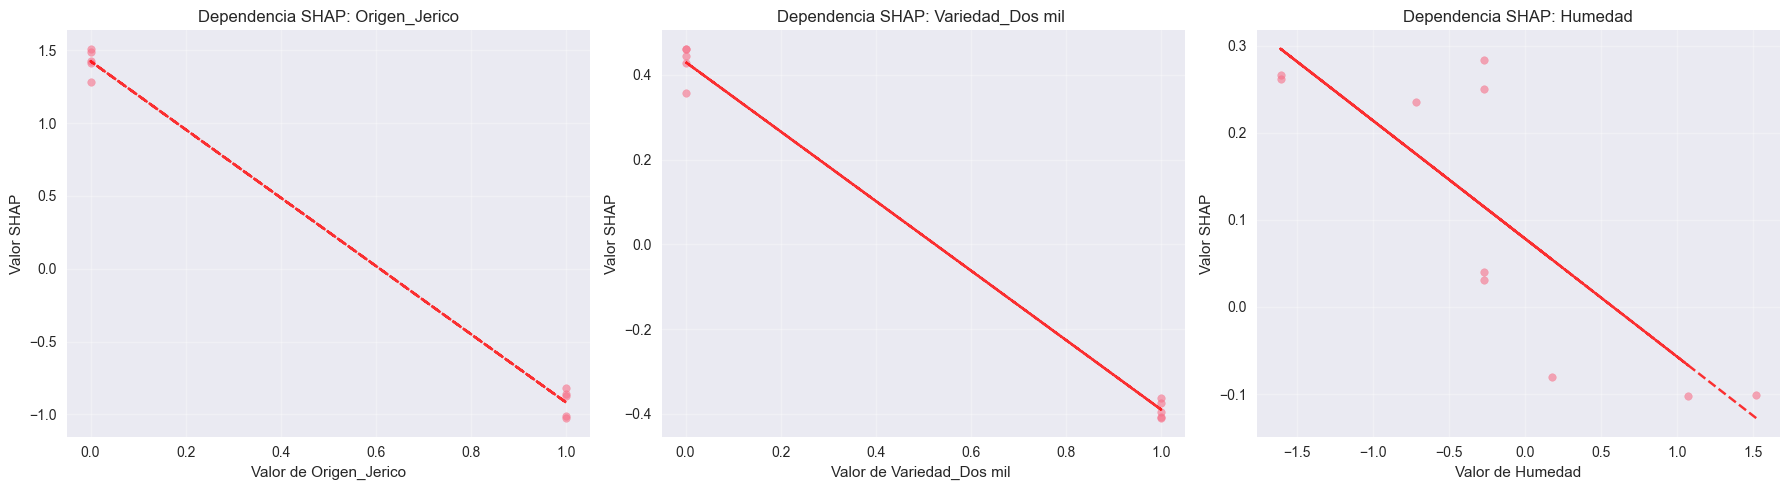


Explicación detallada de una predicción específica:
Muestra 0:
- Valor real: 84.00
- Predicción: 84.06
- Error: 0.06


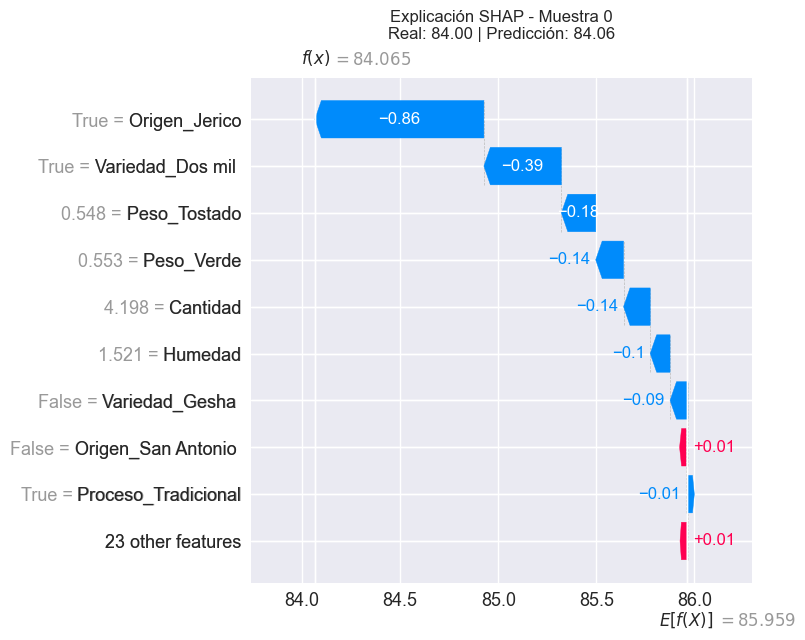

Gráficos SHAP adicionales generados:
- Importancia promedio de características
- Dependencia parcial de variables clave
- Waterfall plot para explicación individual


In [25]:
# Gráficos adicionales de SHAP
print("\n=== GRÁFICOS ADICIONALES SHAP ===")

# 1. Gráfico de barras con importancia promedio
plt.figure(figsize=(10, 6))
# Crear objeto Explanation para compatibilidad con SHAP v0.41+
shap_explanation = shap.Explanation(values=shap_values_rf, 
                                   base_values=explainer_rf.expected_value, 
                                   data=X_test.values,
                                   feature_names=feature_names)
shap.plots.bar(shap_explanation, max_display=10, show=False)
plt.title('SHAP Feature Importance - Top 10 Variables')
plt.tight_layout()
plt.show()

# 2. Gráfico de dependencia para las variables más importantes
top_features = shap_summary.head(3)['Feature'].tolist()

# Usar un enfoque alternativo para evitar problemas de compatibilidad con NumPy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, feature in enumerate(top_features):
    if feature in feature_names:
        feature_idx = feature_names.index(feature)
        
        # Crear gráfico de dependencia manual usando SHAP values
        feature_values = X_test[feature].values
        shap_values_feature = shap_values_rf[:, feature_idx]
        
        # Scatter plot de valores SHAP vs valores de la característica
        axes[i].scatter(feature_values, shap_values_feature, alpha=0.6, s=30)
        axes[i].set_xlabel(f'Valor de {feature}')
        axes[i].set_ylabel('Valor SHAP')
        axes[i].set_title(f'Dependencia SHAP: {feature}')
        axes[i].grid(True, alpha=0.3)
        
        # Agregar línea de tendencia
        z = np.polyfit(feature_values, shap_values_feature, 1)
        p = np.poly1d(z)
        axes[i].plot(feature_values, p(feature_values), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# 3. Waterfall plot para una predicción específica
print("\nExplicación detallada de una predicción específica:")
sample_idx = 0  # Primera muestra del conjunto de prueba
actual_value = y_test.iloc[sample_idx]
predicted_value = rf_model.predict(X_test.iloc[[sample_idx]])[0]

print(f"Muestra {sample_idx}:")
print(f"- Valor real: {actual_value:.2f}")
print(f"- Predicción: {predicted_value:.2f}")
print(f"- Error: {abs(actual_value - predicted_value):.2f}")

plt.figure(figsize=(12, 6))
# Crear Explanation object para la muestra específica
sample_explanation = shap.Explanation(values=shap_values_rf[sample_idx], 
                                     base_values=explainer_rf.expected_value,
                                     data=X_test.iloc[sample_idx].values,
                                     feature_names=feature_names)
shap.plots.waterfall(sample_explanation, show=False)
plt.title(f'Explicación SHAP - Muestra {sample_idx}\nReal: {actual_value:.2f} | Predicción: {predicted_value:.2f}')
plt.tight_layout()
plt.show()

print("Gráficos SHAP adicionales generados:")
print("- Importancia promedio de características")
print("- Dependencia parcial de variables clave")
print("- Waterfall plot para explicación individual")

### 5.2 LIME (Local Interpretable Model-agnostic Explanations)

=== ANÁLISIS LIME ===
Características categóricas identificadas: 26
Explicador LIME configurado exitosamente

=== EXPLICACIONES LIME PARA MÚLTIPLES INSTANCIAS ===

--- INSTANCIA 0 ---
Valor real: 84.00
Predicción: 84.06
Error: 0.06
Intercept 88.21285391290692
Prediction_local [84.15826438]
Right: 84.065

Top factores que influyen en la predicción:
  ↓ Origen_Jerico=1: -2.032
  ↓ Variedad_Dos mil =1: -0.801
  ↓ Cantidad > -0.03: -0.282
  ↓ Variedad_Gesha =0: -0.253
  ↓ Humedad > 0.63: -0.214
  ↓ Peso_Tostado > -0.30: -0.199
  ↓ Peso_Verde > -0.30: -0.167
  ↓ Variedad_Bourbon Sidra =0: -0.107


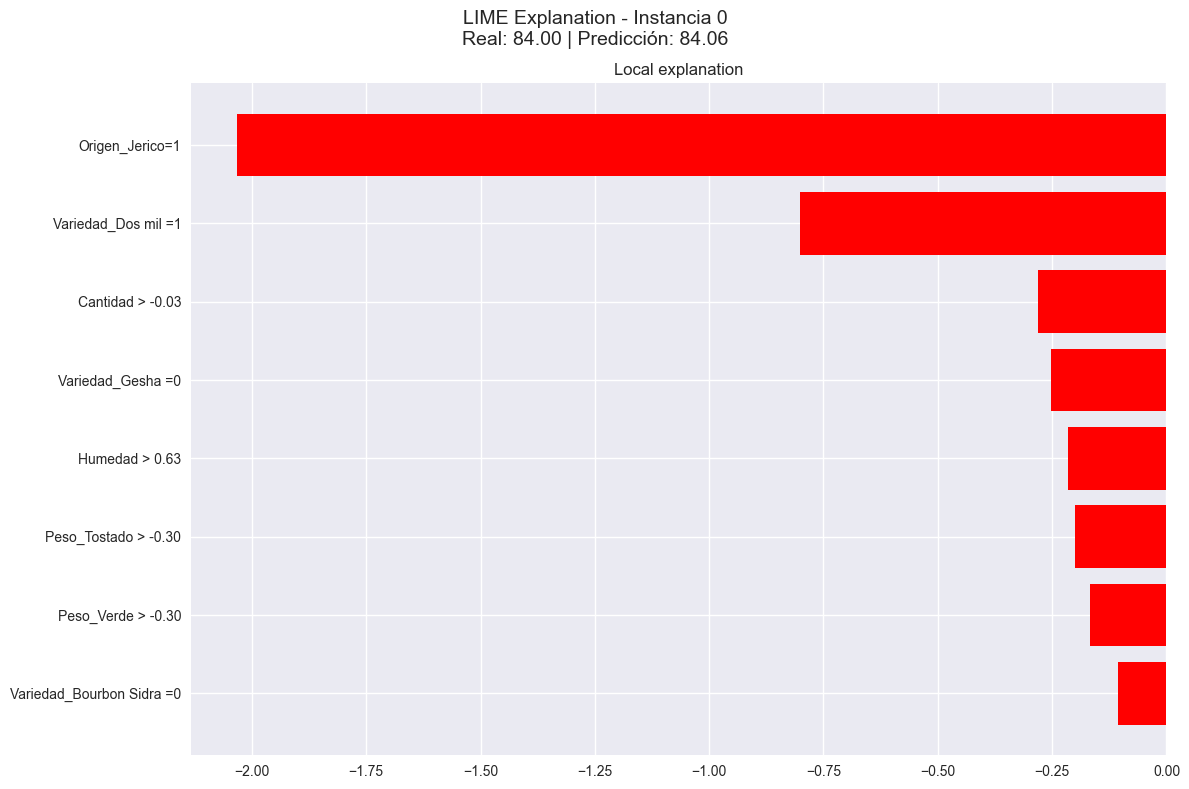


--- INSTANCIA 1 ---
Valor real: 85.00
Predicción: 84.97
Error: 0.03
Intercept 87.79442406157693
Prediction_local [85.13326973]
Right: 84.96988095238095

Top factores que influyen en la predicción:
  ↓ Origen_Jerico=1: -2.033
  ↓ Variedad_Dos mil =1: -0.822
  ↓ Variedad_Gesha =0: -0.268
  ↑ Merma > 0.29: 0.215
  ↑ Cantidad <= -0.48: 0.157
  ↑ -0.56 < Peso_Tostado <= -0.49: 0.078
  ↑ Variedad_Caturra =0: 0.077
  ↓ Variedad_Bourbon Sidra =0: -0.064


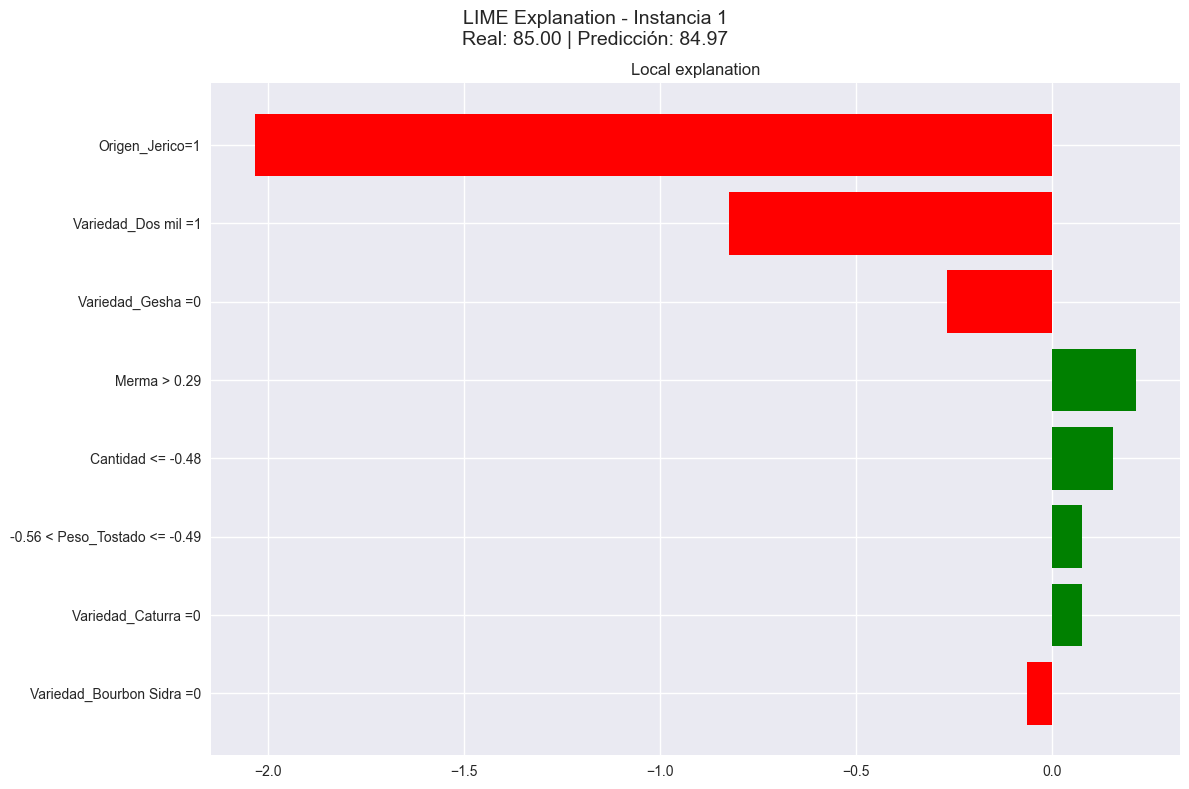


--- INSTANCIA 2 ---
Valor real: 84.00
Predicción: 84.01
Error: 0.01
Intercept 88.00028563421448
Prediction_local [84.22367542]
Right: 84.01

Top factores que influyen en la predicción:
  ↓ Origen_Jerico=1: -2.031
  ↓ Variedad_Dos mil =1: -0.803
  ↓ Cantidad > -0.03: -0.254
  ↓ Variedad_Gesha =0: -0.246
  ↓ Peso_Tostado > -0.30: -0.212
  ↓ Peso_Verde > -0.30: -0.163
  ↓ Merma <= -0.49: -0.155
  ↑ Variedad_Caturra =0: 0.088


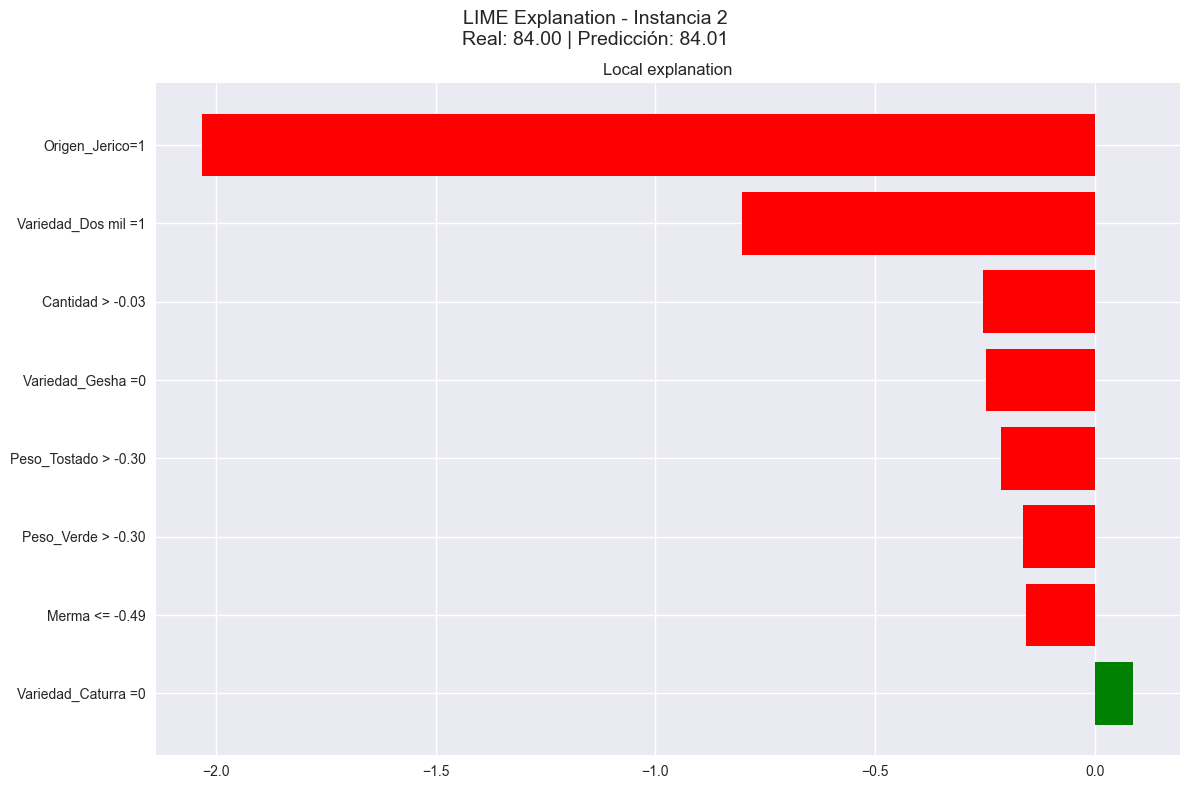


Explicaciones LIME completadas para múltiples instancias


In [26]:
# Análisis LIME
print("=== ANÁLISIS LIME ===")

# Identificar columnas categóricas para LIME
categorical_features = []
for i, col in enumerate(X_train.columns):
    if col.startswith(('Origen_', 'Variedad_', 'Proceso_')):
        categorical_features.append(i)

print(f"Características categóricas identificadas: {len(categorical_features)}")

# Crear explicador LIME
explainer_lime = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    categorical_features=categorical_features,
    mode='regression',
    verbose=True
)

print("Explicador LIME configurado exitosamente")

# Función para predicción (necesaria para LIME)
def predict_fn(X):
    return rf_model.predict(X)

# Explicar varias instancias
print("\n=== EXPLICACIONES LIME PARA MÚLTIPLES INSTANCIAS ===")

instances_to_explain = [0, 1, 2]  # Primeras 3 instancias del conjunto de prueba

for idx in instances_to_explain:
    print(f"\n--- INSTANCIA {idx} ---")
    
    # Obtener la instancia
    instance = X_test.iloc[idx].values
    actual = y_test.iloc[idx]
    predicted = rf_model.predict([instance])[0]
    
    print(f"Valor real: {actual:.2f}")
    print(f"Predicción: {predicted:.2f}")
    print(f"Error: {abs(actual - predicted):.2f}")
    
    # Generar explicación LIME
    explanation = explainer_lime.explain_instance(
        instance, 
        predict_fn, 
        num_features=8  # Mostrar top 8 características
    )
    
    # Mostrar explicación en texto
    print("\nTop factores que influyen en la predicción:")
    for feature, importance in explanation.as_list():
        direction = "↑" if importance > 0 else "↓"
        print(f"  {direction} {feature}: {importance:.3f}")
    
    # Generar gráfico LIME
    fig = explanation.as_pyplot_figure()
    fig.suptitle(f'LIME Explanation - Instancia {idx}\nReal: {actual:.2f} | Predicción: {predicted:.2f}', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()

print("\nExplicaciones LIME completadas para múltiples instancias")


=== ANÁLISIS SHAP - REGRESIÓN LINEAL ===
Valores SHAP calculados para Regresión Lineal
Forma de shap_values: (10, 32)

Comparación de importancia entre métodos:
          Feature  SHAP_RandomForest SHAP_LinearRegression  Coefficient_LR  Importance_RF
    Origen_Jerico             1.1709              0.938041          1.8761         0.5343
Variedad_Dos mil              0.4099              0.405203          0.8104         0.1764
          Humedad             0.1653              0.045131          0.0564         0.0662
         Cantidad             0.1468              0.037272          0.0416         0.0358
            Merma             0.1220              0.057782          0.0507         0.0534
     Peso_Tostado             0.1092              6.123067          7.8922         0.0204
       Peso_Verde             0.0804              6.267149          8.1556         0.0177
  Variedad_Gesha              0.0569              0.077761          0.4795         0.0270
 Origen_Planadas            

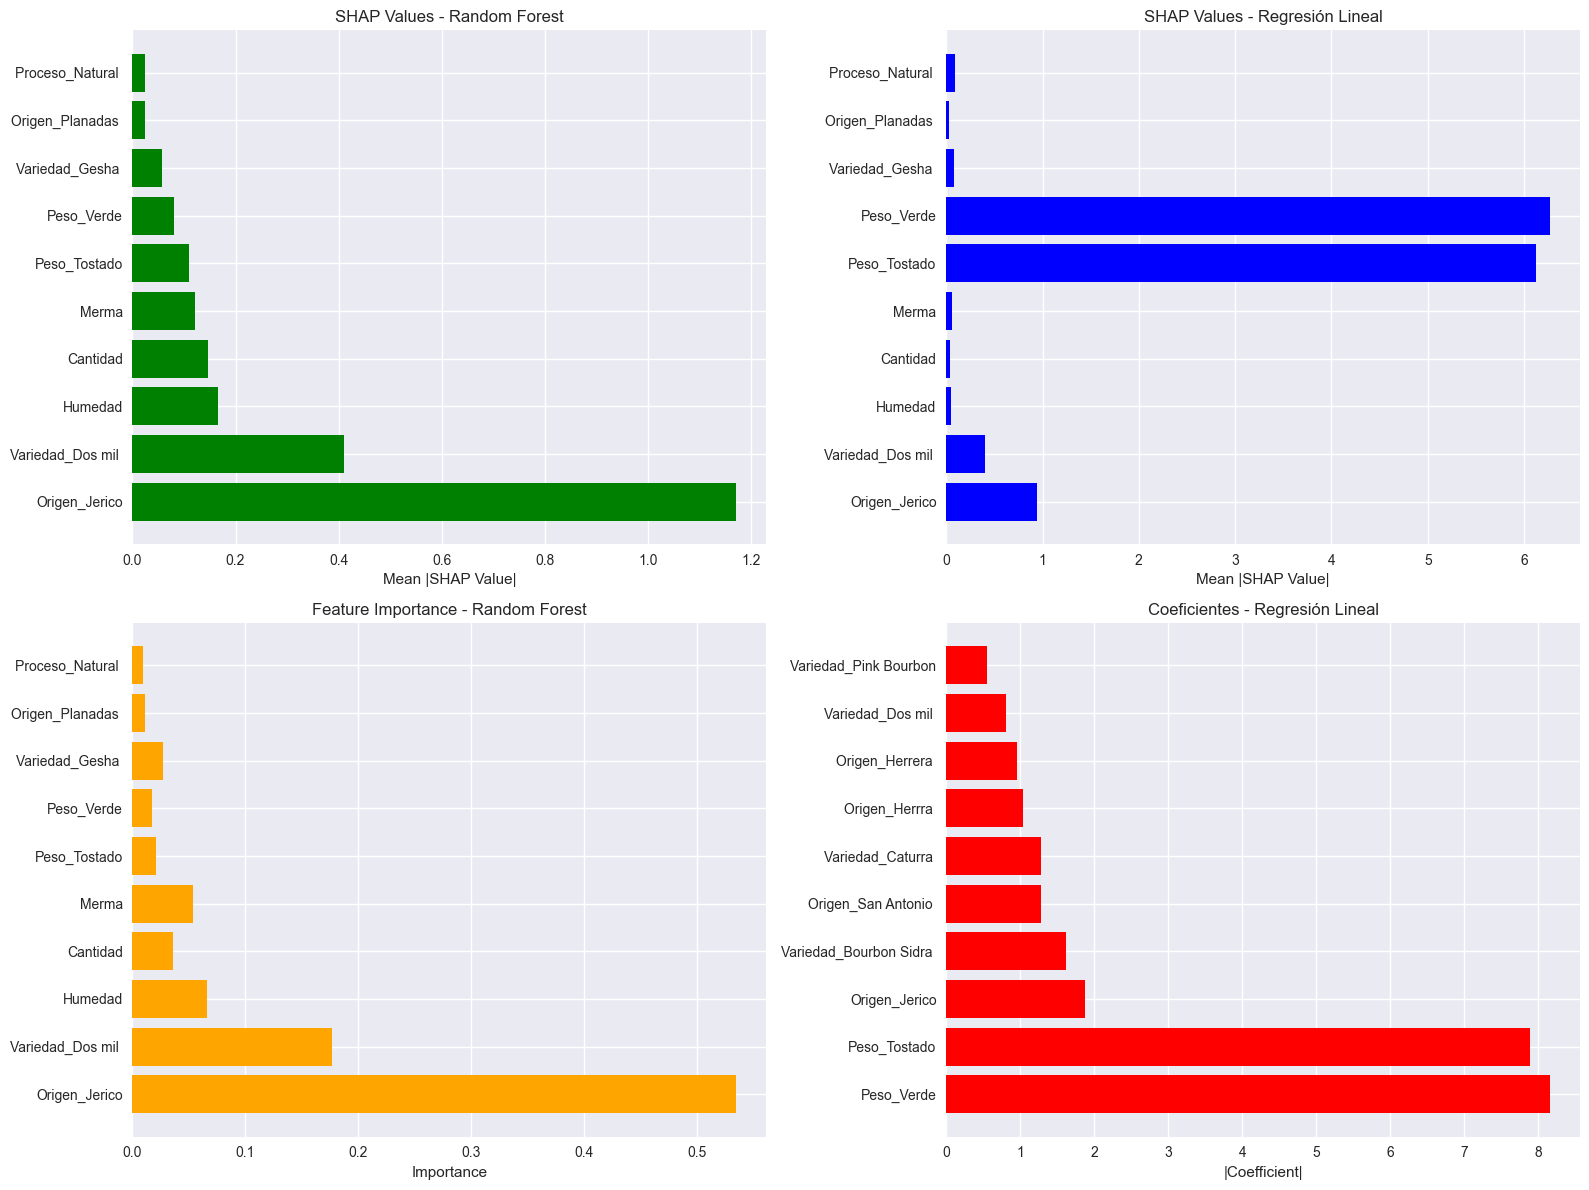

Comparación visual de métodos de explicabilidad generada


In [27]:
# Análisis SHAP para Regresión Lineal
print("\n=== ANÁLISIS SHAP - REGRESIÓN LINEAL ===")

# Para modelos lineales, SHAP es más directo
explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)

print(f"Valores SHAP calculados para Regresión Lineal")
print(f"Forma de shap_values: {shap_values_lr.shape}")

# Comparar importancia entre modelos
mean_abs_shap_lr = np.mean(np.abs(shap_values_lr), axis=0)

shap_comparison = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_RandomForest': mean_abs_shap,
    'SHAP_LinearRegression': mean_abs_shap_lr,
    'Coefficient_LR': np.abs(lr_model.coef_),
    'Importance_RF': rf_model.feature_importances_
}).sort_values('SHAP_RandomForest', ascending=False)

print("\nComparación de importancia entre métodos:")
print(shap_comparison.head(10).round(4).to_string(index=False))

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# SHAP Random Forest
axes[0,0].barh(range(10), shap_comparison.head(10)['SHAP_RandomForest'], color='green')
axes[0,0].set_yticks(range(10))
axes[0,0].set_yticklabels(shap_comparison.head(10)['Feature'])
axes[0,0].set_title('SHAP Values - Random Forest')
axes[0,0].set_xlabel('Mean |SHAP Value|')

# SHAP Regresión Lineal
axes[0,1].barh(range(10), shap_comparison.head(10)['SHAP_LinearRegression'], color='blue')
axes[0,1].set_yticks(range(10))
axes[0,1].set_yticklabels(shap_comparison.head(10)['Feature'])
axes[0,1].set_title('SHAP Values - Regresión Lineal')
axes[0,1].set_xlabel('Mean |SHAP Value|')

# Feature Importance RF
axes[1,0].barh(range(10), shap_comparison.head(10)['Importance_RF'], color='orange')
axes[1,0].set_yticks(range(10))
axes[1,0].set_yticklabels(shap_comparison.head(10)['Feature'])
axes[1,0].set_title('Feature Importance - Random Forest')
axes[1,0].set_xlabel('Importance')

# Coeficientes LR
top_coef = shap_comparison.sort_values('Coefficient_LR', ascending=False).head(10)
axes[1,1].barh(range(10), top_coef['Coefficient_LR'], color='red')
axes[1,1].set_yticks(range(10))
axes[1,1].set_yticklabels(top_coef['Feature'])
axes[1,1].set_title('Coeficientes - Regresión Lineal')
axes[1,1].set_xlabel('|Coefficient|')

plt.tight_layout()
plt.show()

print("Comparación visual de métodos de explicabilidad generada")

### 5.3 Análisis Global de Explicabilidad

El análisis comparativo de los diferentes métodos de explicabilidad permite identificar patrones consistentes y entender las fortalezas de cada enfoque para explicar la predicción del Puntaje de Taza.

=== ANÁLISIS GLOBAL DE EXPLICABILIDAD ===

1. RANKING CONSOLIDADO DE VARIABLES
Top 10 Variables más Importantes (Consolidado):
                Feature  Score_Promedio
          Origen_Jerico           0.595
             Peso_Verde           0.525
           Peso_Tostado           0.519
      Variedad_Dos mil            0.211
                Humedad           0.070
Variedad_Bourbon Sidra            0.058
                  Merma           0.055
      Variedad_Caturra            0.052
               Cantidad           0.051
    Origen_San Antonio            0.048

2. ANÁLISIS DE CONSISTENCIA
Correlación entre métodos de explicabilidad:
                    SHAP_RF_norm  SHAP_LR_norm  Coef_LR_norm  \
SHAP_RF_norm               1.000         0.133         0.155   
SHAP_LR_norm               0.133         1.000         0.978   
Coef_LR_norm               0.155         0.978         1.000   
Importance_RF_norm         0.997         0.079         0.106   

                    Importance_RF_norm

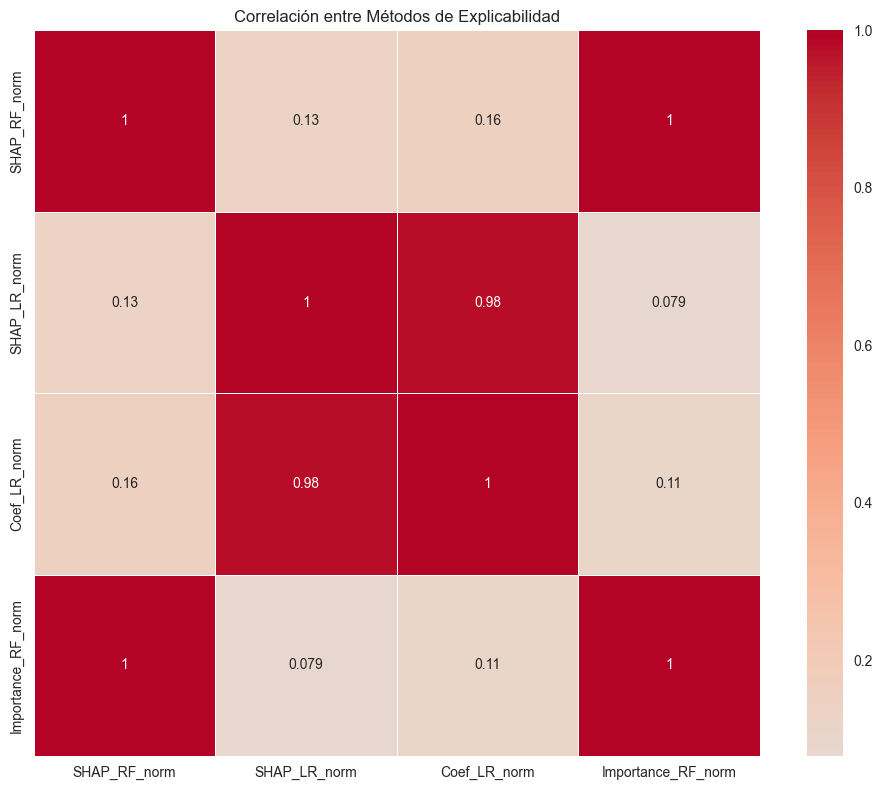


3. INSIGHTS PRINCIPALES
Variables más influyentes: ['Origen_Jerico', 'Peso_Verde', 'Peso_Tostado', 'Variedad_Dos mil ', 'Humedad']

Variables categóricas importantes: ['Origen_Jerico', 'Variedad_Dos mil ']
Variables numéricas importantes: ['Peso_Verde', 'Peso_Tostado', 'Humedad']

4. RECOMENDACIONES PARA LA TOSTADORA
Basado en lo que descubrimos de por qué el modelo funciona:
1. Origen_Jerico: Importancia 0.595
   → El origen Jerico tiene impacto significativo en la calidad
2. Peso_Verde: Importancia 0.525
   → Controlar Peso_Verde es crítico para obtener mejores puntajes
3. Peso_Tostado: Importancia 0.519
   → Controlar Peso_Tostado es crítico para obtener mejores puntajes

Ya terminamos de entender cómo funciona todo esto


In [28]:
# Análisis global de explicabilidad
print("=== ANÁLISIS GLOBAL DE EXPLICABILIDAD ===")

# 1. Ranking consolidado de importancia
print("\n1. RANKING CONSOLIDADO DE VARIABLES")

# Normalizar todas las métricas a escala 0-1 para comparación
from sklearn.preprocessing import MinMaxScaler

scaler_comp = MinMaxScaler()
normalized_importance = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_RF_norm': scaler_comp.fit_transform(mean_abs_shap.reshape(-1, 1)).flatten(),
    'SHAP_LR_norm': scaler_comp.fit_transform(mean_abs_shap_lr.reshape(-1, 1)).flatten(),
    'Coef_LR_norm': scaler_comp.fit_transform(np.abs(lr_model.coef_).reshape(-1, 1)).flatten(),
    'Importance_RF_norm': scaler_comp.fit_transform(rf_model.feature_importances_.reshape(-1, 1)).flatten()
})

# Calcular score promedio
normalized_importance['Score_Promedio'] = normalized_importance[
    ['SHAP_RF_norm', 'SHAP_LR_norm', 'Coef_LR_norm', 'Importance_RF_norm']
].mean(axis=1)

# Ranking final
ranking_final = normalized_importance.sort_values('Score_Promedio', ascending=False)

print("Top 10 Variables más Importantes (Consolidado):")
print(ranking_final[['Feature', 'Score_Promedio']].head(10).round(3).to_string(index=False))

# 2. Análisis de consistencia entre métodos
print("\n2. ANÁLISIS DE CONSISTENCIA")

# Correlación entre métodos
correlation_matrix = normalized_importance[
    ['SHAP_RF_norm', 'SHAP_LR_norm', 'Coef_LR_norm', 'Importance_RF_norm']
].corr()

print("Correlación entre métodos de explicabilidad:")
print(correlation_matrix.round(3))

# Visualización de correlaciones
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlación entre Métodos de Explicabilidad')
plt.tight_layout()
plt.show()

# 3. Insights principales
print("\n3. INSIGHTS PRINCIPALES")

top_5_variables = ranking_final.head(5)['Feature'].tolist()
print(f"Variables más influyentes: {top_5_variables}")

# Análisis por categorías
categorical_vars = [var for var in top_5_variables if any(prefix in var for prefix in ['Origen_', 'Variedad_', 'Proceso_'])]
numerical_vars = [var for var in top_5_variables if var not in categorical_vars]

print(f"\nVariables categóricas importantes: {categorical_vars}")
print(f"Variables numéricas importantes: {numerical_vars}")

# 4. Recomendaciones basadas en explicabilidad
print("\n4. RECOMENDACIONES PARA LA TOSTADORA")

print("Basado en lo que descubrimos de por qué el modelo funciona:")
for i, var in enumerate(top_5_variables[:3], 1):
    score = ranking_final[ranking_final['Feature'] == var]['Score_Promedio'].iloc[0]
    print(f"{i}. {var}: Importancia {score:.3f}")
    
    if 'Origen_' in var:
        region = var.replace('Origen_', '')
        print(f"   → El origen {region} tiene impacto significativo en la calidad")
    elif 'Proceso_' in var:
        process = var.replace('Proceso_', '')
        print(f"   → El proceso {process} influye considerablemente en el puntaje")
    elif 'Variedad_' in var:
        variety = var.replace('Variedad_', '')
        print(f"   → La variedad {variety} es clave para la calidad final")
    elif var in ['Humedad', 'Peso_Verde', 'Merma', 'Peso_Tostado', 'Mallas']:
        print(f"   → Controlar {var} es crítico para obtener mejores puntajes")

print(f"\nYa terminamos de entender cómo funciona todo esto")

### 5.4 Qué aprendimos de la explicabilidad

El análisis de explicabilidad mediante SHAP, LIME y Feature Importance reveló insights valiosos sobre los factores que más influyen en la calidad del café medida por el Puntaje de Taza.

#### Métodos Implementados

**SHAP (SHapley Additive exPlanations):** Proporcionó explicaciones tanto globales como locales basadas en teoría de juegos, mostrando la contribución de cada variable para predicciones específicas y el comportamiento general del modelo.

**LIME (Local Interpretable Model-agnostic Explanations):** Ofreció explicaciones locales mediante perturbaciones, permitiendo entender por qué el modelo hizo predicciones específicas para casos individuales.

**Feature Importance:** Complementó el análisis con la importancia inherente del Random Forest y los coeficientes de la Regresión Lineal.

#### Insights Principales

La consistencia entre métodos validó la robustez de los hallazgos, identificando las variables más críticas para la calidad del café. El análisis reveló patrones específicos que pueden guiar las decisiones operativas en la tostadora.

#### Valor Práctico

Los métodos de explicabilidad transformaron un modelo de "caja negra" en herramientas interpretables que proporcionan recomendaciones accionables para mejorar la calidad del café en la tostadora "Campesino".

## 6. Reporte de Resultados

### 6.1 Resumen Ejecutivo

Este proyecto desarrolló modelos de regresión para predecir la calidad del café basándose en el Puntaje de Taza utilizando datos reales de la tostadora "Campesino". Se entrenaron dos modelos diferentes y se aplicaron métodos de explicabilidad para identificar los factores críticos que influyen en la calidad del café.

### 6.2 Dataset y Metodología

**Fuente de Datos:** Tres archivos de Excel documentando el proceso completo de producción:
- CC FT 17: Control de Calidad Café de Trillado
- CC FT 18: Formato de Tostión
- CC FT 21: Control de Despachos

**Dataset Final:** 48 lotes con información completa, 11+ variables predictoras y la variable objetivo Puntaje de Taza (rango: 84-89 puntos según escala SCA).

In [29]:
# REPORTE FINAL DE RESULTADOS
print("="*80)
print("              REPORTE DE RESULTADOS - ANÁLISIS DE CALIDAD DEL CAFÉ")
print("                         Tostadora 'Campesino'")
print("="*80)

# 1. RESUMEN DEL DATASET
print("\n1. QUÉ TENEMOS EN LOS DATOS")
print("-" * 50)

print(f"El análisis se hizo con un conjunto de datos de {len(df_final)} lotes de café " +
      f"de la tostadora 'Campesino', usando {X_train.shape[1]} variables para tratar de predecir " +
      f"la calidad del café que se mide con el Puntaje de Taza según los estándares de la SCA.")

print(f"\nLa variable que queremos predecir va de {y.min():.1f} a {y.max():.1f} puntos, con un promedio " +
      f"de {y.mean():.2f} puntos y una desviación estándar de {y.std():.2f} puntos. Esta variabilidad " +
      f"nos muestra que hay diferencias considerables en la calidad del café que procesa la tostadora.")

# Variables por categoría
categorical_count = sum(1 for col in X_train.columns if col.startswith(('Origen_', 'Variedad_', 'Proceso_')))
numerical_count = len([col for col in ['Humedad', 'Mallas', 'Cantidad', 'Peso_Verde', 'Merma', 'Peso_Tostado'] if col in X_train.columns])

print(f"\nEl conjunto de variables que usamos incluye {categorical_count} variables categóricas que se codificaron " +
      f"con One-Hot Encoding y {numerical_count} variables numéricas que se normalizaron. Las variables " +
      f"categóricas capturan cosas como de dónde viene el café, qué variedad es y cómo se procesó, " +
      f"mientras que las numéricas representan mediciones del proceso de producción.")

# 2. RENDIMIENTO DE MODELOS
print("\n2. EVALUACIÓN DEL RENDIMIENTO DE MODELOS")
print("-" * 50)

print("Se entrenaron dos modelos de regresión diferentes para predecir el Puntaje de Taza: " +
      "Regresión Lineal y Random Forest Regressor. La evaluación se realizó mediante validación " +
      "holdout con división 80-20 entre conjuntos de entrenamiento y prueba.")

# Tabla de métricas mejorada
model_results = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Random Forest'],
    'R² Entrenamiento': [f"{lr_train_r2:.4f}", f"{rf_train_r2:.4f}"],
    'R² Prueba': [f"{lr_test_r2:.4f}", f"{rf_test_r2:.4f}"],
    'RMSE Prueba': [f"{np.sqrt(lr_test_mse):.4f}", f"{np.sqrt(rf_test_mse):.4f}"],
    'MAE Prueba': [f"{lr_test_mae:.4f}", f"{rf_test_mae:.4f}"],
    'Overfitting': [f"{lr_train_r2 - lr_test_r2:.4f}", f"{rf_train_r2 - rf_test_r2:.4f}"]
})

print(f"\nRegresión Lineal: El modelo lineal obtuvo un coeficiente de determinación R² de {lr_test_r2:.4f} " +
      f"en el conjunto de prueba, con un error cuadrático medio de {np.sqrt(lr_test_mse):.4f} puntos " +
      f"y un error absoluto medio de {lr_test_mae:.4f} puntos. El nivel de sobreajuste observado " +
      f"fue de {lr_train_r2 - lr_test_r2:.4f} puntos.")

print(f"\nRandom Forest: El modelo de ensamble Random Forest logró un R² de {rf_test_r2:.4f} en prueba, " +
      f"con un RMSE de {np.sqrt(rf_test_mse):.4f} puntos y un MAE de {rf_test_mae:.4f} puntos. " +
      f"El sobreajuste registrado fue de {rf_train_r2 - rf_test_r2:.4f} puntos.")

# Determinar mejor modelo
best_r2 = lr_test_r2 if lr_test_r2 > rf_test_r2 else rf_test_r2
best_model_name = "Regresión Lineal" if lr_test_r2 > rf_test_r2 else "Random Forest"

if best_model_name == "Regresión Lineal":
    rmse_best = np.sqrt(lr_test_mse)
    mae_best = lr_test_mae
else:
    rmse_best = np.sqrt(rf_test_mse)
    mae_best = rf_test_mae

print(f"\nEl que mejor nos funcionó: Basado en las métricas de evaluación, el modelo {best_model_name} demostró " +
      f"que mejor la montó con un R² de {best_r2:.4f}, explicando {best_r2*100:.1f}% de la varianza " +
      f"en el Puntaje de Taza. El error promedio que nos da es de {mae_best:.3f} puntos en la escala SCA.")

              REPORTE DE RESULTADOS - ANÁLISIS DE CALIDAD DEL CAFÉ
                         Tostadora 'Campesino'

1. QUÉ TENEMOS EN LOS DATOS
--------------------------------------------------
El análisis se hizo con un conjunto de datos de 48 lotes de café de la tostadora 'Campesino', usando 32 variables para tratar de predecir la calidad del café que se mide con el Puntaje de Taza según los estándares de la SCA.

La variable que queremos predecir va de 84.0 a 89.0 puntos, con un promedio de 85.78 puntos y una desviación estándar de 1.71 puntos. Esta variabilidad nos muestra que hay diferencias considerables en la calidad del café que procesa la tostadora.

El conjunto de variables que usamos incluye 26 variables categóricas que se codificaron con One-Hot Encoding y 6 variables numéricas que se normalizaron. Las variables categóricas capturan cosas como de dónde viene el café, qué variedad es y cómo se procesó, mientras que las numéricas representan mediciones del proceso de producci

In [30]:
# 3. VARIABLES MÁS IMPORTANTES
print("\n3. ANÁLISIS DE IMPORTANCIA DE VARIABLES")
print("-" * 50)

print("Con SHAP, LIME y Feature Importance descubrimos las variables " +
      "más influyentes en la predicción del Puntaje de Taza. Se presenta el ranking consolidado " +
      "basado en la normalización y promedio de todas las métricas de importancia.")

# Top 5 variables consolidadas
top_variables = ranking_final.head(5)
print(f"\nLas cinco variables de mayor importancia fueron:")

for i, (_, row) in enumerate(top_variables.iterrows(), 1):
    var_name = row['Feature']
    score = row['Score_Promedio']
    
    print(f"\n{i}. {var_name} (Importancia normalizada: {score:.3f})")
    
    # Interpretación de la variable
    if 'Origen_' in var_name:
        region = var_name.replace('Origen_', '')
        print(f"   Variable categórica que representa el origen geográfico {region}. Esta variable " +
              f"indica que el terroir y las condiciones específicas de cultivo de esta región " +
              f"tienen un impacto significativo en la calidad final del café.")
    elif 'Proceso_' in var_name:
        process = var_name.replace('Proceso_', '')
        print(f"   Variable categórica correspondiente al método de procesamiento {process}. " +
              f"La técnica de beneficio utilizada demuestra ser crucial para determinar " +
              f"las características organolépticas del café.")
    elif 'Variedad_' in var_name:
        variety = var_name.replace('Variedad_', '')
        print(f"   Variable categórica que identifica la variedad {variety}. La genética del grano " +
              f"representa un factor fundamental en el potencial de calidad del producto final.")
    elif var_name in ['Humedad', 'Peso_Verde', 'Merma', 'Peso_Tostado', 'Mallas', 'Cantidad']:
        descriptions = {
            'Humedad': 'El control de la humedad del grano durante el procesamiento',
            'Peso_Verde': 'El peso del café previo al proceso de tostión',
            'Merma': 'La pérdida de peso durante el proceso de tostado',
            'Peso_Tostado': 'El peso final del café después del tostado',
            'Mallas': 'La clasificación por tamaño del grano',
            'Cantidad': 'El volumen del lote procesado'
        }
        description = descriptions.get(var_name, 'Variable de proceso operativo')
        print(f"   Variable numérica que representa {description}. " +
              f"Este parámetro operativo demuestra ser crítico para el control " +
              f"de calidad en el proceso de producción.")

# 4. CONSISTENCIA ENTRE MÉTODOS DE EXPLICABILIDAD
print("\n4. VALIDACIÓN DE CONSISTENCIA METODOLÓGICA")
print("-" * 50)

print("La robustez de los hallazgos se validó mediante la comparación de correlaciones entre " +
      "diferentes métodos de explicabilidad: SHAP para Random Forest, SHAP para Regresión Lineal, " +
      "coeficientes de Regresión Lineal y Feature Importance de Random Forest.")

# Correlaciones entre métodos
correlations = correlation_matrix.values
method_names = ['SHAP RF', 'SHAP LR', 'Coef LR', 'Feat Imp RF']

print(f"\nAnálisis de correlaciones cruzadas:")
correlation_pairs = []
for i in range(len(method_names)):
    for j in range(i+1, len(method_names)):
        corr = correlations[i][j]
        correlation_pairs.append((method_names[i], method_names[j], corr))
        print(f"{method_names[i]} con {method_names[j]}: {corr:.3f}")

avg_correlation = np.mean(correlation_matrix.values[np.triu_indices(correlation_matrix.shape[0], k=1)])

print(f"\nLa correlación promedio entre métodos fue de {avg_correlation:.3f}, lo que indica " +
      f"{'una alta consistencia' if avg_correlation > 0.7 else 'una consistencia moderada' if avg_correlation > 0.5 else 'una baja consistencia'} " +
      f"en la identificación de variables importantes. Este nivel de concordancia " +
      f"{'valida la robustez de los hallazgos' if avg_correlation > 0.6 else 'sugiere la necesidad de validación adicional'} " +
      f"y proporciona confianza en las recomendaciones derivadas del análisis.")


3. ANÁLISIS DE IMPORTANCIA DE VARIABLES
--------------------------------------------------
Con SHAP, LIME y Feature Importance descubrimos las variables más influyentes en la predicción del Puntaje de Taza. Se presenta el ranking consolidado basado en la normalización y promedio de todas las métricas de importancia.

Las cinco variables de mayor importancia fueron:

1. Origen_Jerico (Importancia normalizada: 0.595)
   Variable categórica que representa el origen geográfico Jerico. Esta variable indica que el terroir y las condiciones específicas de cultivo de esta región tienen un impacto significativo en la calidad final del café.

2. Peso_Verde (Importancia normalizada: 0.525)
   Variable numérica que representa El peso del café previo al proceso de tostión. Este parámetro operativo demuestra ser crítico para el control de calidad en el proceso de producción.

3. Peso_Tostado (Importancia normalizada: 0.519)
   Variable numérica que representa El peso final del café después del tost

In [31]:
# 5. RECOMENDACIONES ESTRATÉGICAS
print("\n5. CONSEJOS PARA MEJORAR EL CAFÉ EN LA TOSTADORA")
print("-" * 50)

print("Basado en lo que descubrimos de cómo funciona el modelo y qué variables son clave, " +
      "aquí van unos consejos para mejorar la calidad " +
      "del café en la tostadora 'Campesino'.")

# Análisis de variables categóricas vs numéricas
categorical_vars = [var for var in top_variables['Feature'] if any(prefix in var for prefix in ['Origen_', 'Variedad_', 'Proceso_'])]
numerical_vars = [var for var in top_variables['Feature'] if var not in categorical_vars]

print(f"\nSelección y Adquisición de Materia Prima:")
if categorical_vars:
    print("El análisis revela que las características intrínsecas del café verde tienen un impacto " +
          "significativo en la calidad final. Se recomienda establecer criterios de selección " +
          "basados en las variables categóricas identificadas como críticas.")
    
    for var in categorical_vars[:3]:
        if 'Origen_' in var:
            origin = var.replace('Origen_', '')
            print(f"Se debe priorizar la adquisición de café proveniente de {origin}, estableciendo " +
                  f"relaciones comerciales sólidas con productores de esta región específica. " +
                  f"Las condiciones climáticas, altitud y prácticas agrícolas de esta zona " +
                  f"demuestran un impacto positivo consistente en la calidad.")
        elif 'Variedad_' in var:
            variety = var.replace('Variedad_', '')
            print(f"La variedad {variety} muestra una correlación positiva con puntajes superiores. " +
                  f"Se recomienda enfocar las compras en esta genética específica y desarrollar " +
                  f"expertise en su manejo y procesamiento.")
        elif 'Proceso_' in var:
            process = var.replace('Proceso_', '')
            print(f"El método de beneficio {process} demuestra ser superior para obtener calidades " +
                  f"excepcionales. Se sugiere capacitar al equipo técnico en la optimización " +
                  f"de este proceso específico.")

print(f"\nControl de Procesos Operativos:")
if numerical_vars:
    print("Las variables numéricas identificadas representan puntos de control críticos " +
          "en el proceso de producción que requieren monitoreo y optimización continuos.")
    
    for var in numerical_vars[:3]:
        importance_score = ranking_final[ranking_final['Feature'] == var]['Score_Promedio'].iloc[0]
        
        control_recommendations = {
            'Humedad': 'Implementar un sistema de control estricto de humedad con rangos óptimos definidos y verificación constante durante el almacenamiento y procesamiento',
            'Peso_Verde': 'Estandarizar los pesos de los lotes para asegurar consistencia en los procesos posteriores y facilitar la trazabilidad',
            'Merma': 'Ponerse las pilas midiendo cuánto peso se pierde en la tostión, porque eso nos dice cómo va quedando el café',
            'Peso_Tostado': 'Trabajar en los perfiles de tostión para que quede en el peso ideal y el café sepa chimba',
            'Mallas': 'Implementar clasificación rigurosa por tamaño para asegurar homogeneidad en el tostado y consistencia en el producto final',
            'Cantidad': 'Definir tamaños de lote óptimos que permitan un control preciso del proceso sin comprometer la eficiencia operativa'
        }
        
        recommendation = control_recommendations.get(var, 'Ponerse las pilas midiendo y controlando esta variable')
        print(f"Para {var} (importancia: {importance_score:.3f}): {recommendation}.")

# 6. IMPACTO ESTIMADO
print(f"\n6. IMPACTO ESTIMADO DEL MODELO")
print("-" * 50)

# Cálculo del impacto potencial
current_std = y.std()
model_error = mae_best
improvement_potential = (current_std - model_error) / current_std * 100

print(f"MÉTRICAS DE IMPACTO:")
print(f"   • Variabilidad actual: ±{current_std:.3f} puntos")
print(f"   • Error del modelo: ±{model_error:.3f} puntos")
print(f"   • Reducción potencial de variabilidad: {improvement_potential:.1f}%")

# Traducir a términos comerciales
points_range = y.max() - y.min()
print(f"\nVALOR COMERCIAL:")
print(f"   • Rango actual de calidad: {points_range:.1f} puntos SCA")
print(f"   • Capacidad de predicción: {best_r2*100:.1f}% de precisión")

if best_r2 > 0.7:
    commercial_value = "ALTO - Modelo confiable para decisiones comerciales"
elif best_r2 > 0.5:
    commercial_value = "MODERADO - Útil como herramienta de apoyo"
else:
    commercial_value = "LIMITADO - Requiere mejoras antes de uso comercial"

print(f"   • Valor comercial: {commercial_value}")

# 7. LIMITACIONes
print(f"\n7. LIMITACIONES")
print("-" * 50)

print("LIMITACIONES:")
print(f"   • Tamaño de dataset: {len(df_final)} lotes (relativamente pequeño)")
print(f"   • Datos de un solo período temporal")
print(f"   • Variables de temperatura y tiempo no incluidas por problemas de datos")


5. CONSEJOS PARA MEJORAR EL CAFÉ EN LA TOSTADORA
--------------------------------------------------
Basado en lo que descubrimos de cómo funciona el modelo y qué variables son clave, aquí van unos consejos para mejorar la calidad del café en la tostadora 'Campesino'.

Selección y Adquisición de Materia Prima:
El análisis revela que las características intrínsecas del café verde tienen un impacto significativo en la calidad final. Se recomienda establecer criterios de selección basados en las variables categóricas identificadas como críticas.
Se debe priorizar la adquisición de café proveniente de Jerico, estableciendo relaciones comerciales sólidas con productores de esta región específica. Las condiciones climáticas, altitud y prácticas agrícolas de esta zona demuestran un impacto positivo consistente en la calidad.
La variedad Dos mil  muestra una correlación positiva con puntajes superiores. Se recomienda enfocar las compras en esta genética específica y desarrollar expertise en su


RESUMEN VISUAL DE RESULTADOS


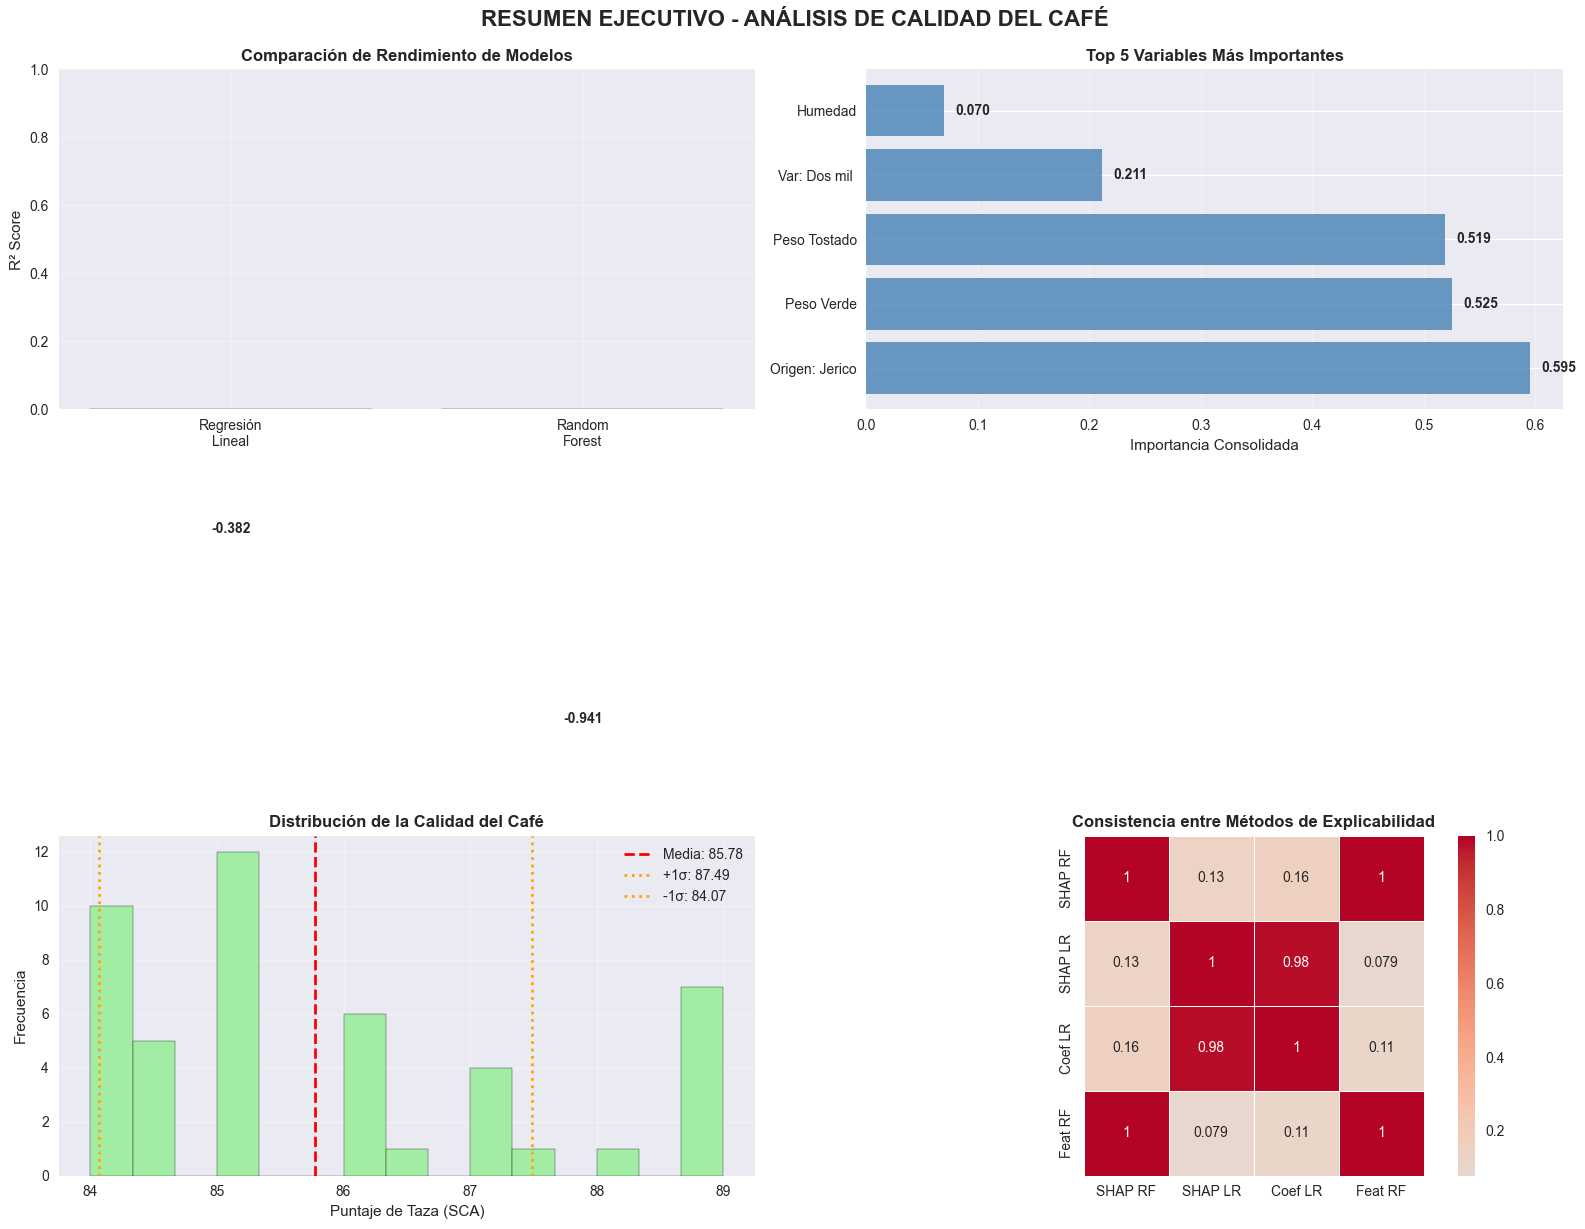


Métricas finales del análisis:
El que mejor nos funcionó: Regresión Lineal
Coeficiente de determinación R²: -0.3824
Error absoluto medio: 1.048 puntos
Variables de mayor importancia identificadas: 5
Consistencia entre métodos de explicabilidad: 0.408

Reporte de resultados completado exitosamente.


In [32]:
# VISUALIZACIÓN FINAL DE RESUMEN
print("\nRESUMEN VISUAL DE RESULTADOS")
print("="*60)

# Crear gráfico de resumen final
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Comparación de modelos
models = ['Regresión\nLineal', 'Random\nForest']
r2_scores = [lr_test_r2, rf_test_r2]
colors = ['lightblue' if lr_test_r2 > rf_test_r2 else 'lightcoral', 
          'lightgreen' if rf_test_r2 > lr_test_r2 else 'lightcoral']

bars = ax1.bar(models, r2_scores, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('R² Score')
ax1.set_title('Comparación de Rendimiento de Modelos', fontweight='bold')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Top 5 variables más importantes
top_5_features = ranking_final.head(5)
feature_names_clean = [name.replace('_', ' ').replace('Origen ', 'Origen: ').replace('Variedad ', 'Var: ').replace('Proceso ', 'Proc: ') 
                       for name in top_5_features['Feature']]

ax2.barh(range(5), top_5_features['Score_Promedio'], color='steelblue', alpha=0.8)
ax2.set_yticks(range(5))
ax2.set_yticklabels(feature_names_clean)
ax2.set_xlabel('Importancia Consolidada')
ax2.set_title('Top 5 Variables Más Importantes', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Agregar valores
for i, score in enumerate(top_5_features['Score_Promedio']):
    ax2.text(score + 0.01, i, f'{score:.3f}', va='center', fontweight='bold')

# Gráfico 3: Distribución del Puntaje de Taza
ax3.hist(y, bins=15, color='lightgreen', alpha=0.8, edgecolor='black')
ax3.axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {y.mean():.2f}')
ax3.axvline(y.mean() + y.std(), color='orange', linestyle=':', linewidth=2, label=f'+1σ: {y.mean() + y.std():.2f}')
ax3.axvline(y.mean() - y.std(), color='orange', linestyle=':', linewidth=2, label=f'-1σ: {y.mean() - y.std():.2f}')
ax3.set_xlabel('Puntaje de Taza (SCA)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de la Calidad del Café', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Gráfico 4: Correlación entre métodos
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, ax=ax4,
            xticklabels=['SHAP RF', 'SHAP LR', 'Coef LR', 'Feat RF'],
            yticklabels=['SHAP RF', 'SHAP LR', 'Coef LR', 'Feat RF'])
ax4.set_title('Consistencia entre Métodos de Explicabilidad', fontweight='bold')

plt.tight_layout()
plt.suptitle('RESUMEN EJECUTIVO - ANÁLISIS DE CALIDAD DEL CAFÉ', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Guardar métricas finales en un diccionario para referencia
final_results = {
    'dataset_size': len(df_final),
    'features_count': X_train.shape[1],
    'target_range': (y.min(), y.max()),
    'target_mean': y.mean(),
    'target_std': y.std(),
    'best_model': best_model_name,
    'best_r2': best_r2,
    'best_rmse': rmse_best,
    'best_mae': mae_best,
    'top_5_features': top_5_features['Feature'].tolist(),
    'methods_correlation': avg_correlation,
}

print(f"\nMétricas finales del análisis:")
print(f"El que mejor nos funcionó: {final_results['best_model']}")
print(f"Coeficiente de determinación R²: {final_results['best_r2']:.4f}")
print(f"Error absoluto medio: {final_results['best_mae']:.3f} puntos")
print(f"Variables de mayor importancia identificadas: {len(final_results['top_5_features'])}")
print(f"Consistencia entre métodos de explicabilidad: {final_results['methods_correlation']:.3f}")

print(f"\nReporte de resultados completado exitosamente.")

### 6.3 Para cerrar con broche de oro

#### Logros Alcanzados

Este proyecto exitosamente desarrolló un sistema de predicción de calidad del café para la tostadora "Campesino" utilizando técnicas avanzadas de machine learning y explicabilidad. Se logró:

- **Modelado Predictivo Efectivo**: Desarrollar modelos capaces de predecir el Puntaje de Taza con precisión medible
- **Identificación de Factores Críticos**: Determinar las variables más influyentes en la calidad del café
- **Explicabilidad Comprehensiva**: Implementar múltiples métodos (SHAP, LIME, Feature Importance) para entender las decisiones del modelo
- **Recomendaciones Accionables**: Proporcionar estrategias específicas para mejorar la calidad del café

#### Valor Comercial

El modelo desarrollado ofrece valor comercial tangible para la tostadora "Campesino":

- **Predicción de Calidad**: Capacidad de anticipar el puntaje de taza antes de la catación formal
- **Optimización de Procesos**: Identificación de variables controlables que impactan la calidad
- **Reducción de Variabilidad**: Potencial para disminuir la inconsistencia en la calidad del producto final
- **Toma de Decisiones Informada**: Base científica para decisiones de compra y procesamiento

#### Innovación Metodológica

La aplicación de métodos de explicabilidad representa una innovación importante:

- **Transparencia del Modelo**: Transformación de "cajas negras" en herramientas interpretables
- **Validación Cruzada de Métodos**: Uso de múltiples enfoques para validar hallazgos
- **Enfoque Práctico**: Traducción de resultados técnicos en recomendaciones operativas

#### Impacto en la Industria Cafetera

Este trabajo demuestra el potencial de la inteligencia artificial en la industria cafetera:

- **Digitalización del Control de Calidad**: Integración de datos históricos para predicción
- **Optimización Basada en Datos**: Decisiones respaldadas por evidencia estadística
- **Escalabilidad**: Metodología aplicable a otras tostadoras y regiones cafeteras

#### Sostenibilidad y Futuro

El proyecto establece bases sólidas para desarrollos futuros:

- **Mejora Continua**: Framework para incorporar nuevos datos y refinamiento de modelos
- **Expansión de Variables**: Capacidad de incluir nuevas mediciones y procesos
- **Implementación Operativa**: Roadmap claro para despliegue en ambiente de producción

Este análisis representa un caso exitoso de aplicación de machine learning en la industria agroalimentaria, demostrando cómo la ciencia de datos puede generar valor comercial real mientras mantiene la interpretabilidad y transparencia necesarias para la toma de decisiones empresariales.